The Start of the project

**Importing the required libraries**

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
from scipy import stats

%matplotlib inline


import warnings
warnings.filterwarnings('ignore')

import yfinance as yf

from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Ref: https://towardsdatascience.com/8-commonly-used-pandas-display-options-you-should-know-a832365efa95
# ADJUST COLUMN WIDTH IN PANDAS TO SHOW ALL TEXT
# (FOR MODEL PERFORMANCE DISPLAY LATER)

pd.set_option('display.max_colwidth', None)


# PRE-SET PATH TO images FOLDER TO SAVE PLOTS LATER
directory_to_img = os.path.join('..', '..', 'images')

In [ ]:
pip install --upgrade yfinance


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.4/117.4 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 53.5 MB/s eta 0:00:00
  Attempting uninstall: yfinance
    Found existing installation: yfinance 0.2.57
    Uninstalling yfinance-0.2.57:
      Successfully uninstalled yfinance-0.2.57


Load data and Y finance for API

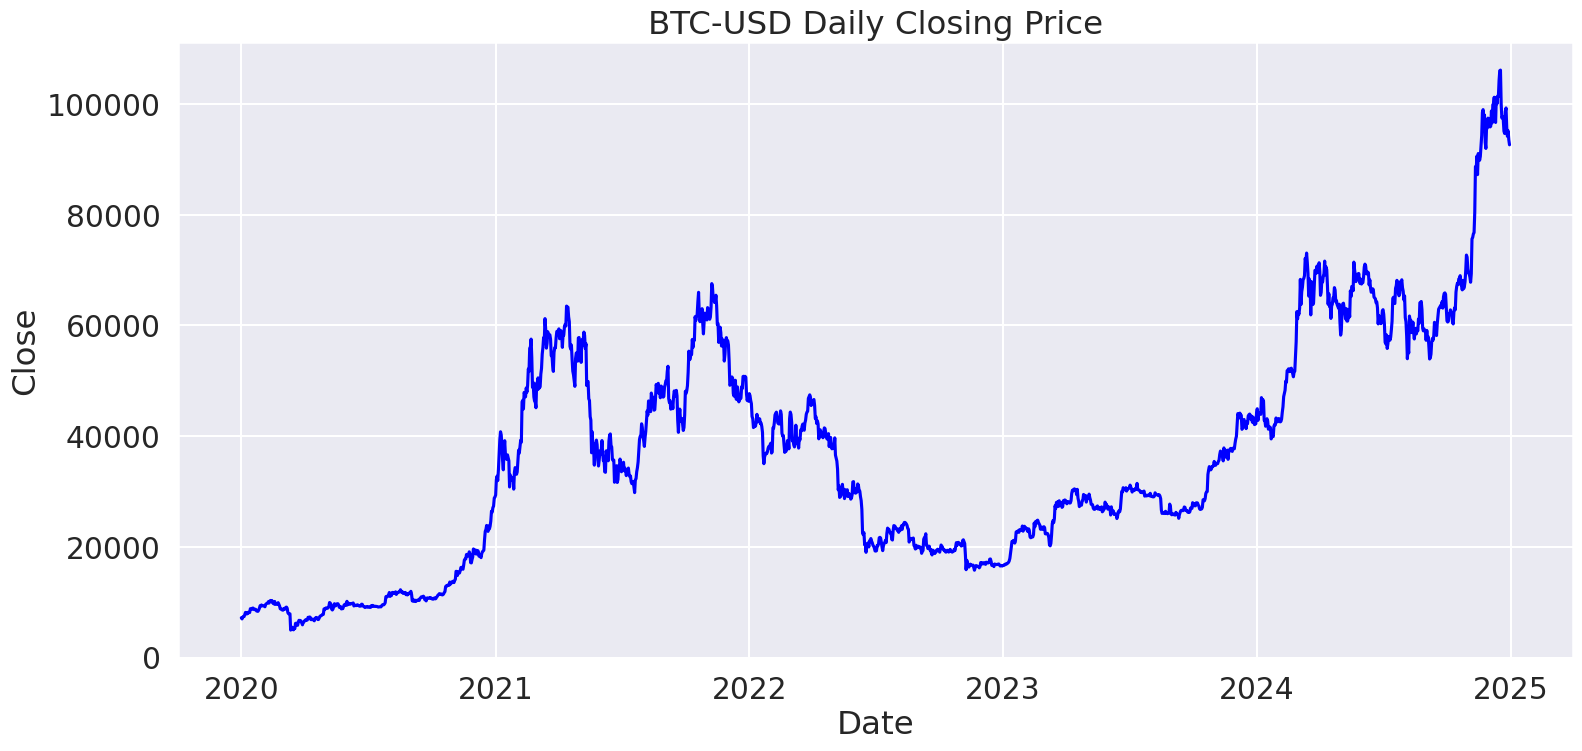

In [ ]:
import time
# SET SEED FOR REPRODUCIBILITY

seed = 2021
# SELECT START AND END DATE
start = datetime(2020, 1, 1)
end = datetime(2024, 12, 31)


tckr = 'BTC-USD'

ticker = yf.Ticker(tckr)
df = ticker.history(start=start,end=end,interval="1d")
time.sleep(30)
# CHANGE CONTEXT TO poster TO INCREASE FONT SIZES
sns.set_context("talk", font_scale=1.3)

# PLOT OUT BTC-USE'S CLOSING PRICES SINCE 2014
with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(18,8))
    sns.lineplot(x=df.index, y=df.Close, color='blue')
    ax.set_title('BTC-USD Daily Closing Price')

Volatility

In [ ]:
df['returns'] = 100 * df.Close.pct_change().dropna()

In [ ]:
# CALCULATE LOG RETURNS BASED ON ABOVE FORMULA
df['log_returns'] = np.log(df.Close/df.Close.shift(1))

In [ ]:
df.head()

Open         High          Low        Close  \
Date                                                                            
2020-01-01 00:00:00+00:00  7194.892090  7254.330566  7174.944336  7200.174316   
2020-01-02 00:00:00+00:00  7202.551270  7212.155273  6935.270020  6985.470215   
2020-01-03 00:00:00+00:00  6984.428711  7413.715332  6914.996094  7344.884277   
2020-01-04 00:00:00+00:00  7345.375488  7427.385742  7309.514160  7410.656738   
2020-01-05 00:00:00+00:00  7410.451660  7544.497070  7400.535645  7411.317383   

                                Volume  Dividends  Stock Splits   returns  \
Date                                                                        
2020-01-01 00:00:00+00:00  18565664997        0.0           0.0       NaN   
2020-01-02 00:00:00+00:00  20802083465        0.0           0.0 -2.981929   
2020-01-03 00:00:00+00:00  28111481032        0.0           0.0  5.145166   
2020-01-04 00:00:00+00:00  18444271275        0.0           0.0  0.895487   
2020-01-05 00:00:00+00:00  19725074095        0.0           0.0  0.008915   

                           log_returns  
Date                                    
2020-01-01 00:00:00+00:00          NaN  
2020-01-02 00:00:00+00:00    -0.030273  
2020-01-03 00:00:00+00:00     0.050172  
2020-01-04 00:00:00+00:00     0.008915  
2020-01-05 00:00:00+00:00     0.000089

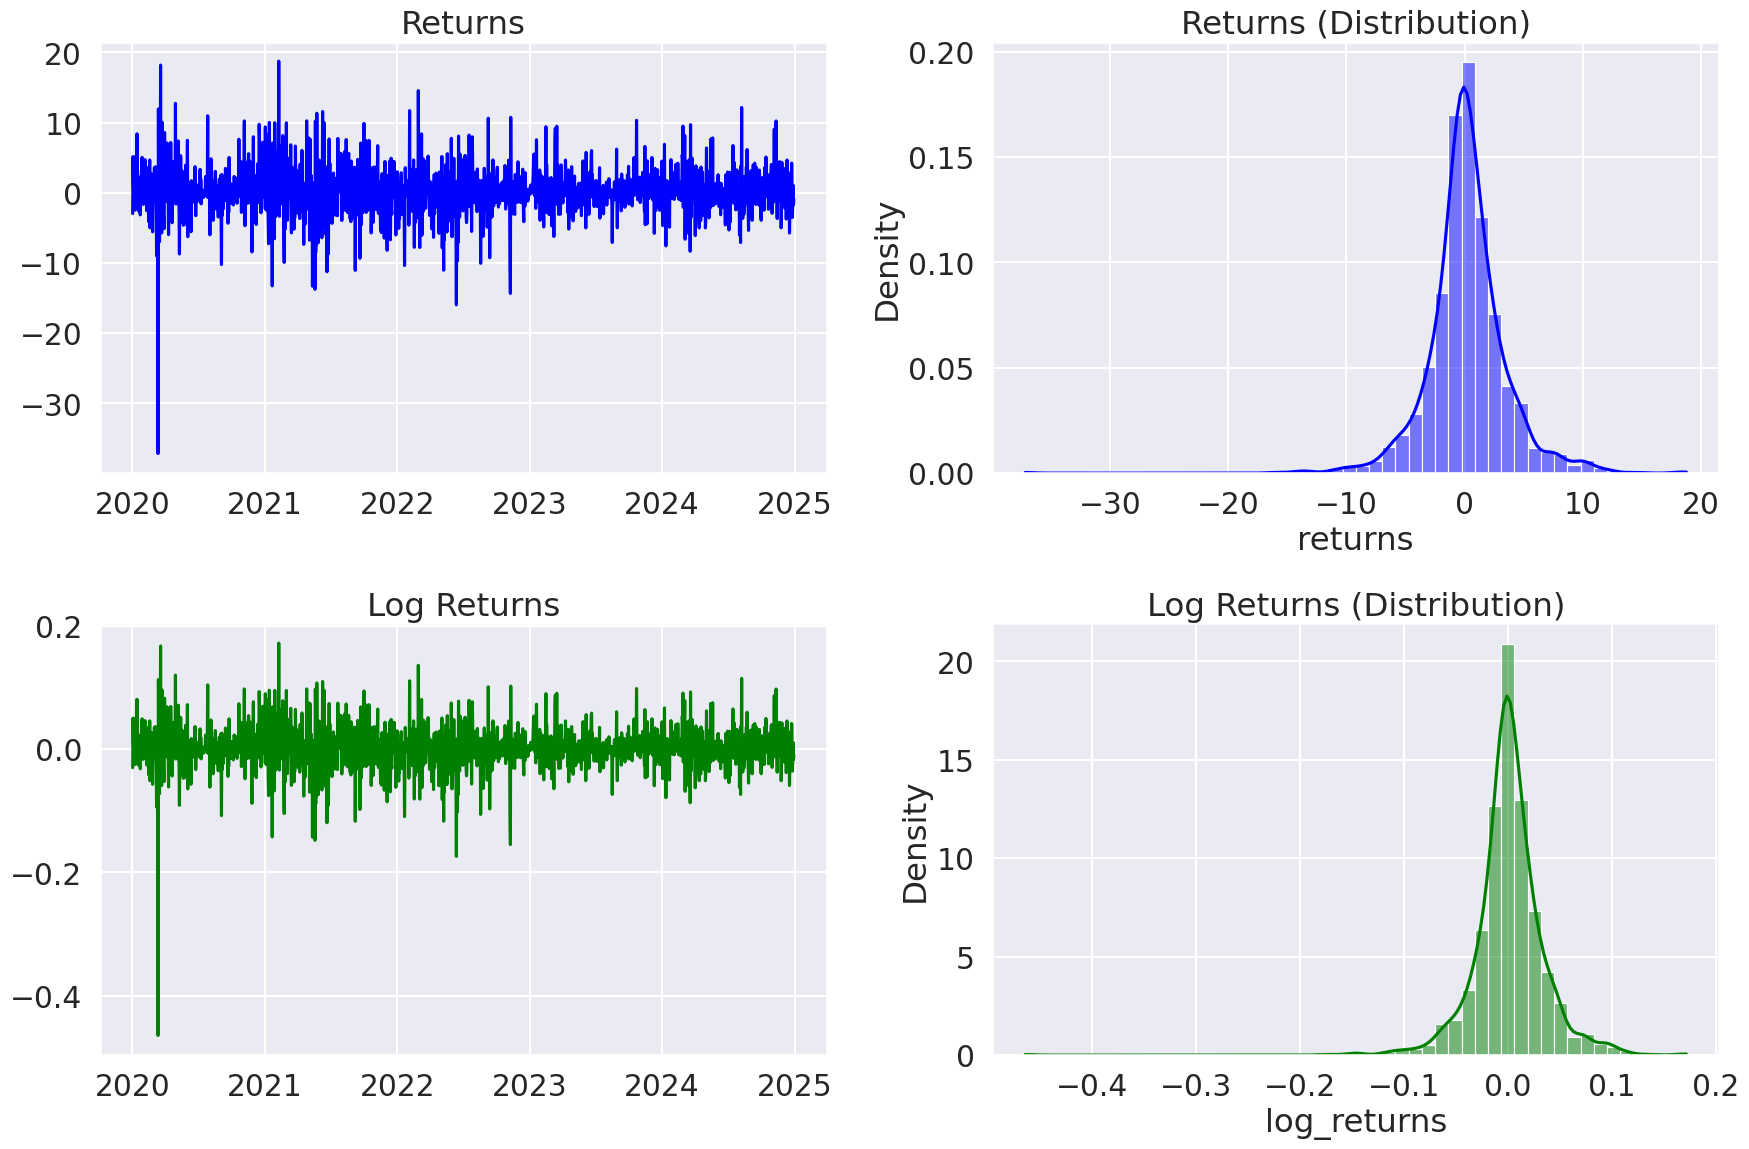

In [ ]:
# DROPPING THE 1ST ROW OF DATA
# BECAUSE I SHIFTED IT FORWARD TO CALCULATE RETURNS/LOG RETURNS
df.dropna(inplace=True)

# PLOT DISTRIBUTION PLOTS OF RETURNS & LOG RETURNS
# AND VISUALLY COMPARE THEM WITH THE STANDARD NORMAL DISTRIBUTION
with sns.axes_style("darkgrid"):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18,12))

    # Time series plot of percentage returns
    axes[0][0].plot(df.returns, color='blue')
    axes[0][0].set_title('Returns')

    # Histogram + normal distribution fit of returns
    sns.histplot(df.returns, stat='density', kde=True, bins=50,
                 color='blue', ax=axes[0][1])
    stats.norm.fit(df.returns)  # This is for visual reference
    axes[0][1].set_title('Returns (Distribution)')

    # Time series plot of log returns
    axes[1][0].plot(df.log_returns, color='green')
    axes[1][0].set_title('Log Returns')

    # Histogram + normal distribution fit of log returns
    sns.histplot(df.log_returns, stat='density', kde=True, bins=50,
                 color='green', ax=axes[1][1])
    stats.norm.fit(df.log_returns)  # Again, for reference
    axes[1][1].set_title('Log Returns (Distribution)')

    plt.tight_layout()
    plt.show()


In [ ]:
df.returns.describe()



count    1825.000000
mean        0.197425
std         3.355454
min       -37.169539
25%        -1.291715
50%         0.065967
75%         1.654447
max        18.746474
Name: returns, dtype: float64

In [ ]:
df.log_returns.describe()


count    1825.000000
mean        0.001400
std         0.034086
min        -0.464730
25%        -0.013001
50%         0.000659
75%         0.016409
max         0.171821
Name: log_returns, dtype: float64

Both Returns & Log Returns show some:

slight Positive skewness
positive kurtosis (leptokurtic) - higher peak with thicker tails than the standard normal distribution.


### Types of Volatility and How to Calculate Them from Log Returns

The standard deviation will be different for log returns computed over longer or shorter intervals.  
For this specific project, the volatility would be for a certain fixed interval window (`INTERVAL_WINDOW`).  
This is the standard deviation of log returns, or the square root of the sum of squares of log returns:

σ_interval = √( Σ_t (r_{t-1,t})² )

To scale the volatility to different frequencies (daily, weekly, monthly, yearly),  
we multiply the result by the square root of the frequency in terms of days, divided by (INTERVAL_WINDOW - 1).

#### Examples:

- **Daily Volatility**:
  
  σ_daily = √( Σ_t (r_{t-1,t})² ) * √( 1 / (INTERVAL_WINDOW - 1) )

- **Annualized Volatility**:

  σ_annualized = √( Σ_t (r_{t-1,t})² ) * √( 365 / (INTERVAL_WINDOW - 1) )

- **Monthly Volatility**:

  σ_monthly = √( Σ_t (r_{t-1,t})² ) * √( 30 / (INTERVAL_WINDOW - 1) )

- **Weekly Volatility**:

  σ_weekly = √( Σ_t (r_{t-1,t})² ) * √( 7 / (INTERVAL_WINDOW - 1) )


In [ ]:

# CREATE A FUNCTION THAT CALCULATE REALIZED VOLATILITY
# FROM SAILY LOG RETURNS
def realized_volatility_daily(series_log_return):
    """
    Get the daily realized volatility which is calculated as the square root
    of sum of squares of log returns within a specific window interval
    """
    n = len(series_log_return)
    return np.sqrt(np.sum(series_log_return**2)/(n - 1))

**Interval Window Selection**\
For this specific project I'll use an interval window of 30 days (equivalent to roughly 1 month of trading for cryptocurrencies). The goal here is to forecast the average realized volatility of the next n_future 7 days using all previous available datapoint with GARCH models (expanding window forecasting), and using a number of immediate past/historical datapoints (n_past) with Neural Networks (sliding window forecasting).

In [ ]:
intervals = [7, 30, 60, 180, 365]
vols_df = {}

# ITERATE OVER intervals LIST
for i in intervals:
    # GET DAILY LOG RETURNS USING THAT INTERVAL
    vols = df.log_returns.rolling(window=i)\
                         .apply(realized_volatility_daily).values

    vols_df[i] = vols

# CONVERT vols_df FROM DICTIONARY TO PANDAS DATAFRAME
vols_df = pd.DataFrame(vols_df, columns=intervals, index=df.index)

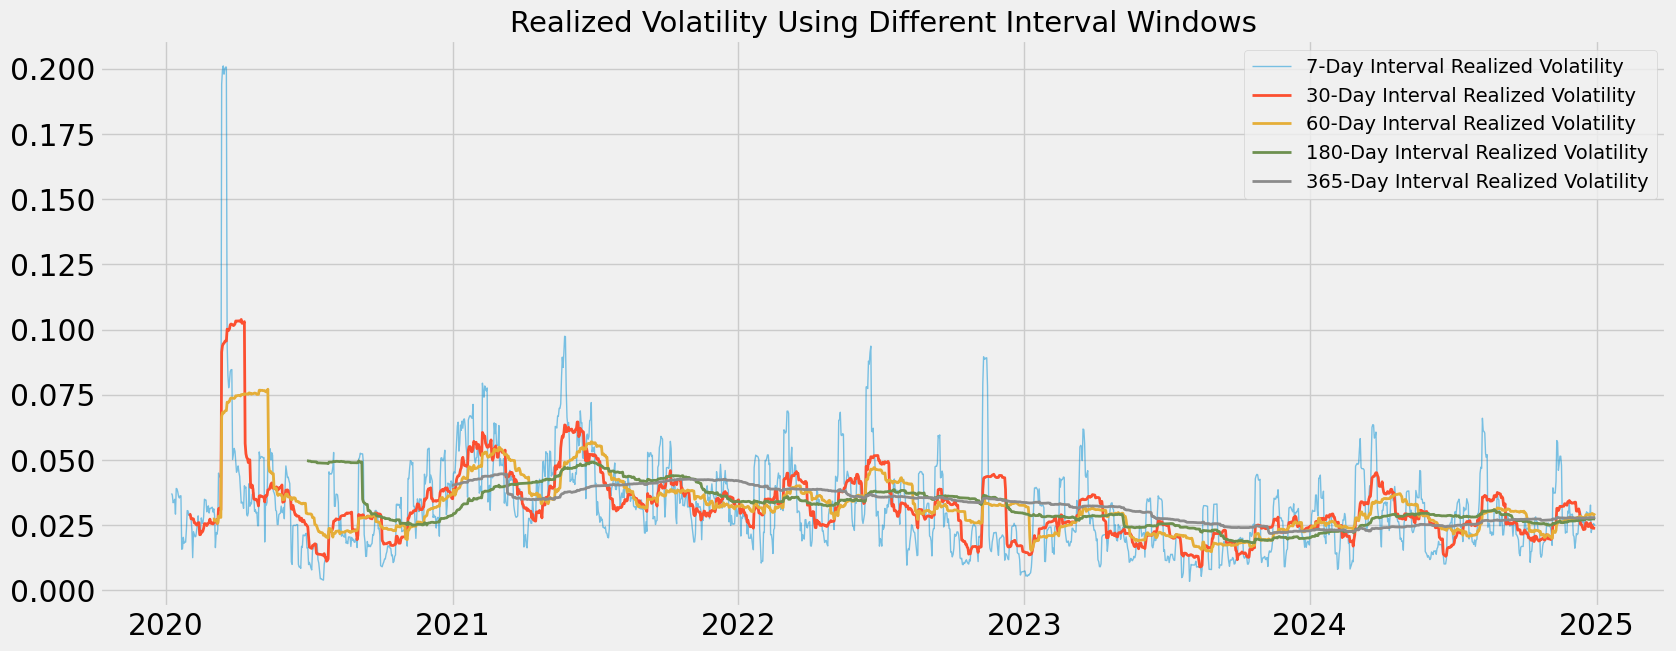

In [ ]:
# CHANGING MATPLOTLIB STYLE
plt.style.use(['fivethirtyeight'])

fig, ax = plt.subplots(figsize=(18,7))

for i in intervals:
    if i == 7:
        alpha = 0.5
        lw = 1
    else:
        alpha = 1.0
        lw = 2
    ax.plot(vols_df[i], label=f'{i}-Day Interval Realized Volatility',
            alpha=alpha, lw=lw)

ax.set_title('Realized Volatility Using Different Interval Windows', fontsize=21)

plt.legend(loc='best', prop={'size': 14})


The reason I selected 30 days is because 7 days seems too noisy to observe meaningful patterns, while longer intervals seem to smooth the volatility down significantly and tend to revert back to the mean.

Using interval window of 30 days would also help avoid wasting too many datapoints at the beginning of the dataset.

Time-series forecasting models are the models that are capable to predict future values based on previously observed values. Target "future" data in this case is obtained by shifting the current volatility backward by the number of n_future lags.

For example, respected to last week's Monday, this week's Monday is the "future"; therefore I just need to shift the volatility this week back by 7 days, and use it as the desired "future" output for last week's, which I would then use for Neural Networks training and model performance evaluation.



In [ ]:
INTERVAL_WINDOW = 30
n_future = 7

# GET BACKWARD LOOKING REALIZED VOLATILITY
df['vol_current'] = df.log_returns.rolling(window=INTERVAL_WINDOW)\
                                   .apply(realized_volatility_daily)

# GET FORWARD LOOKING REALIZED VOLATILITY
df['vol_future'] = df.log_returns.shift(-n_future)\
                                 .rolling(window=INTERVAL_WINDOW)\
                                 .apply(realized_volatility_daily)

In [ ]:
df.describe()

Open           High            Low          Close  \
count    1825.000000    1825.000000    1825.000000    1825.000000   
mean    36257.710661   37055.332949   35429.799053   36302.022015   
std     21049.980642   21517.644340   20568.360977   21077.989056   
min      5002.578125    5331.833984    4106.980957    4970.788086   
25%     19615.154297   20127.234375   19261.447266   19623.580078   
50%     32138.873047   33327.101562   31030.265625   32186.277344   
75%     50667.648438   51868.679688   49072.378906   50700.085938   
max    106147.296875  108268.445312  105291.734375  106140.601562   

             Volume  Dividends  Stock Splits      returns  log_returns  \
count  1.825000e+03     1825.0        1825.0  1825.000000  1825.000000   
mean   3.318099e+10        0.0           0.0     0.197425     0.001400   
std    1.952189e+10        0.0           0.0     3.355454     0.034086   
min    5.331173e+09        0.0           0.0   -37.169539    -0.464730   
25%    2.061032e+10        0.0           0.0    -1.291715    -0.013001   
50%    2.993834e+10        0.0           0.0     0.065967     0.000659   
75%    4.017700e+10        0.0           0.0     1.654447     0.016409   
max    3.509679e+11        0.0           0.0    18.746474     0.171821   

       vol_current   vol_future  
count  1796.000000  1789.000000  
mean      0.031959     0.031975  
std       0.013736     0.013760  
min       0.009005     0.009005  
25%       0.023776     0.023740  
50%       0.029474     0.029563  
75%       0.037153     0.037194  
max       0.103878     0.103878

In [ ]:
df = df.drop(['Dividends', 'Stock Splits'], axis=1)


In [ ]:
df.describe()

Open           High            Low          Close  \
count    1825.000000    1825.000000    1825.000000    1825.000000   
mean    36257.710661   37055.332949   35429.799053   36302.022015   
std     21049.980642   21517.644340   20568.360977   21077.989056   
min      5002.578125    5331.833984    4106.980957    4970.788086   
25%     19615.154297   20127.234375   19261.447266   19623.580078   
50%     32138.873047   33327.101562   31030.265625   32186.277344   
75%     50667.648438   51868.679688   49072.378906   50700.085938   
max    106147.296875  108268.445312  105291.734375  106140.601562   

             Volume      returns  log_returns  vol_current   vol_future  
count  1.825000e+03  1825.000000  1825.000000  1796.000000  1789.000000  
mean   3.318099e+10     0.197425     0.001400     0.031959     0.031975  
std    1.952189e+10     3.355454     0.034086     0.013736     0.013760  
min    5.331173e+09   -37.169539    -0.464730     0.009005     0.009005  
25%    2.061032e+10    -1.291715    -0.013001     0.023776     0.023740  
50%    2.993834e+10     0.065967     0.000659     0.029474     0.029563  
75%    4.017700e+10     1.654447     0.016409     0.037153     0.037194  
max    3.509679e+11    18.746474     0.171821     0.103878     0.103878

Since I am currently using an INTERVAL_WINDOW of 30 and a horizon n_future of 7, the volatilty of first 30 values as well as the last 7 values of the dataframe would be NaN, and therefore need to be dropped from the dataset.

In [ ]:
# DROPPING ALL NaN VALUES
df.dropna(inplace=True)

# EDA

First I would just plot out my desired target outputs vol_future with respect to the current volatility vol_current. The first plot shows all the datapoints I have available that covers 5 years, but then the second plot is only zooming in the most recent 365 days.

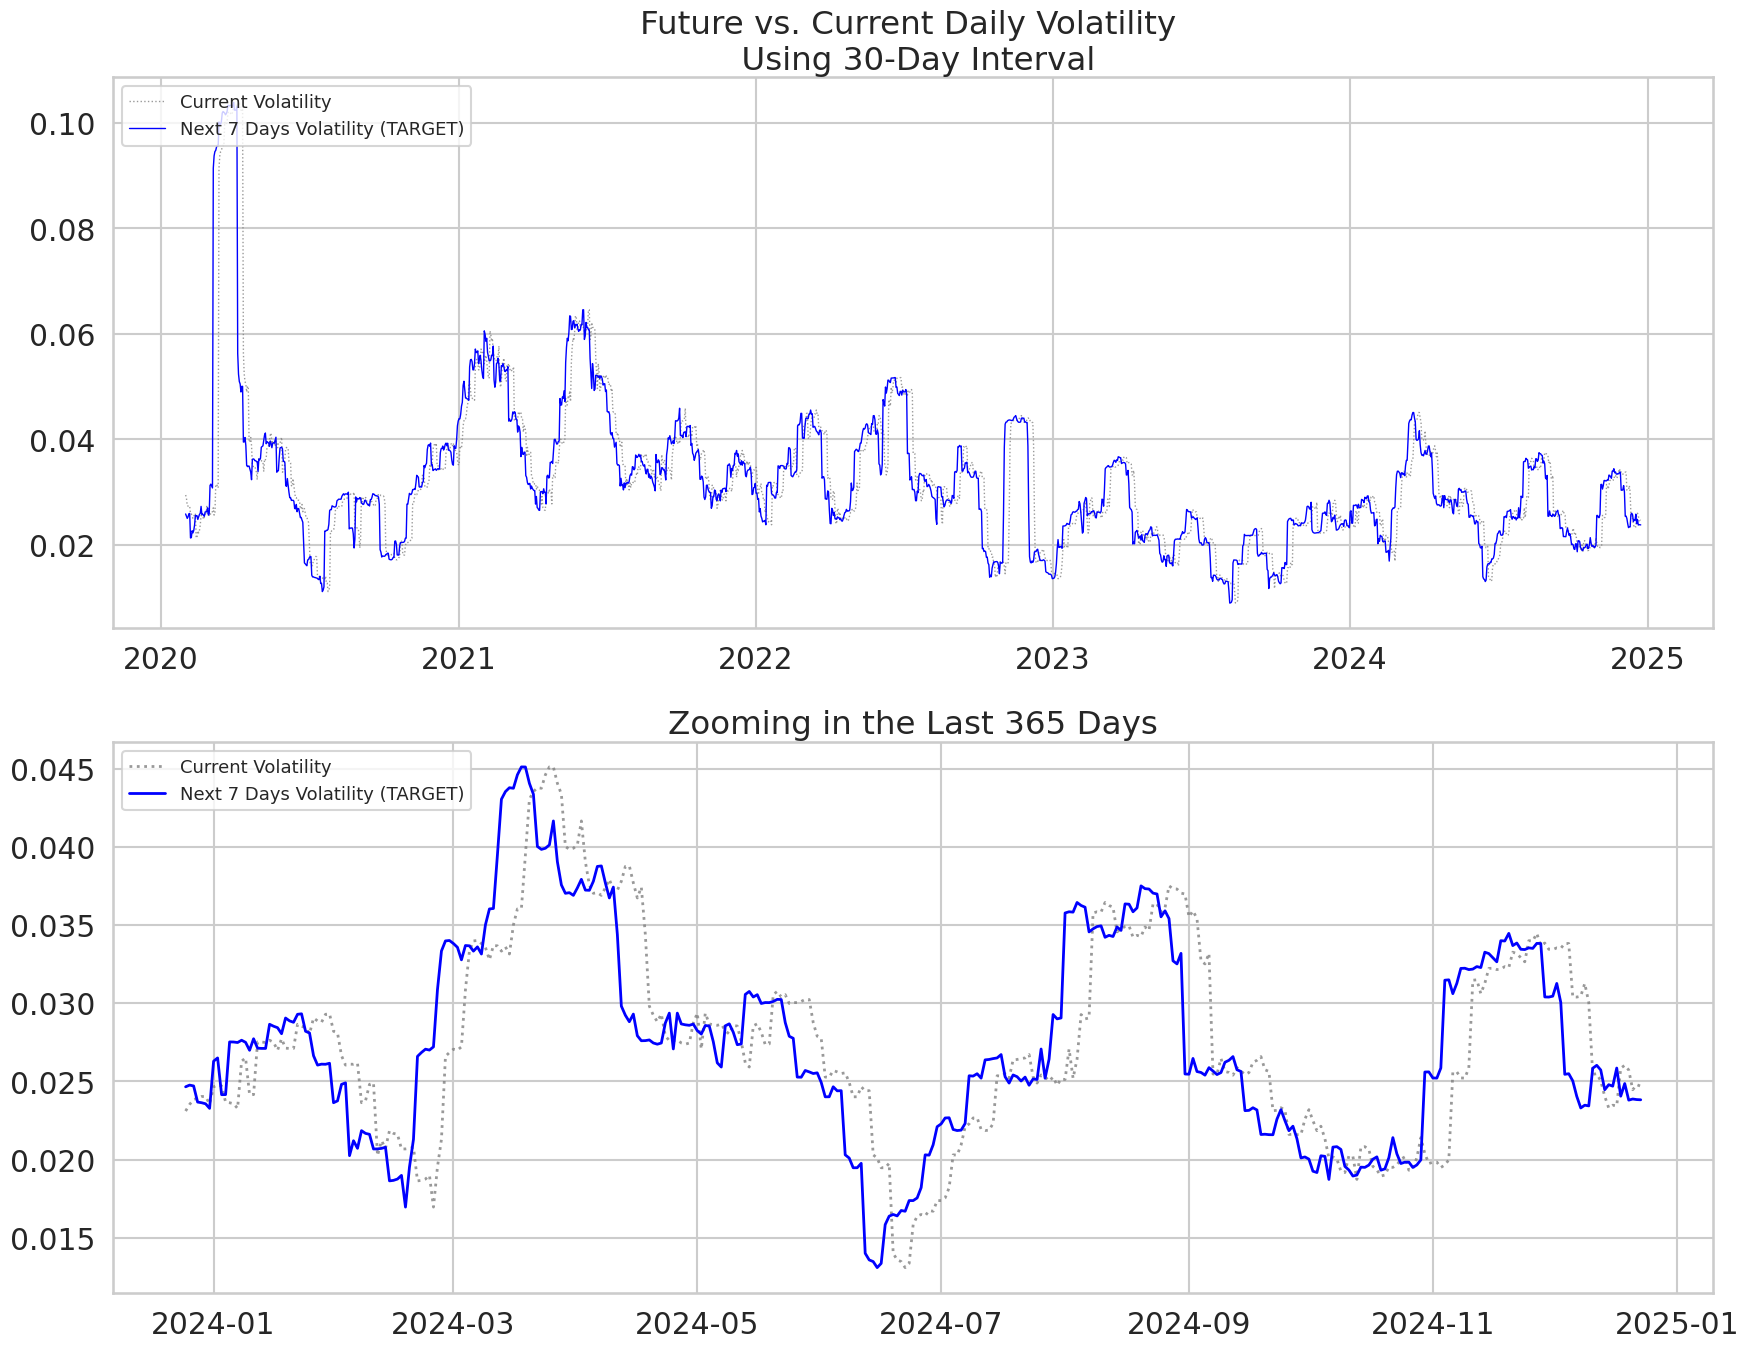

In [ ]:
n_zoom = 365
sns.set_context("talk", font_scale=1.3)
# plt.style.use(['seaborn'])

# VISUALIZE REALIZED CURRENT VS. FUTURE VOLATILITY
with sns.axes_style("whitegrid"):
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(18,14))

    ax1.plot(df.vol_current, alpha=.8, lw=1, color='gray', ls=':',
            label='Current Volatility')
    ax1.plot(df.vol_future, lw=1, color='blue',
            label=f'Next {n_future} Days Volatility (TARGET)')

    ax2.plot(df.vol_current[-n_zoom:], alpha=.8, lw=2, color='gray', ls=':',
            label='Current Volatility')
    ax2.plot(df.vol_future[-n_zoom:], lw=2, color='blue',
            label=f'Next {n_future} Days Volatility (TARGET)')

    ax1.title.set_text(f'Future vs. Current Daily Volatility \n Using {INTERVAL_WINDOW}-Day Interval')
    ax2.title.set_text(f'Zooming in the Last {n_zoom} Days')

    ax1.legend(loc='upper left', prop={'size': 13}, frameon=True)
    ax2.legend(loc='upper left', prop={'size': 13}, frameon=True)
    plt.tight_layout()

# Daily Volatility Grouped by Month


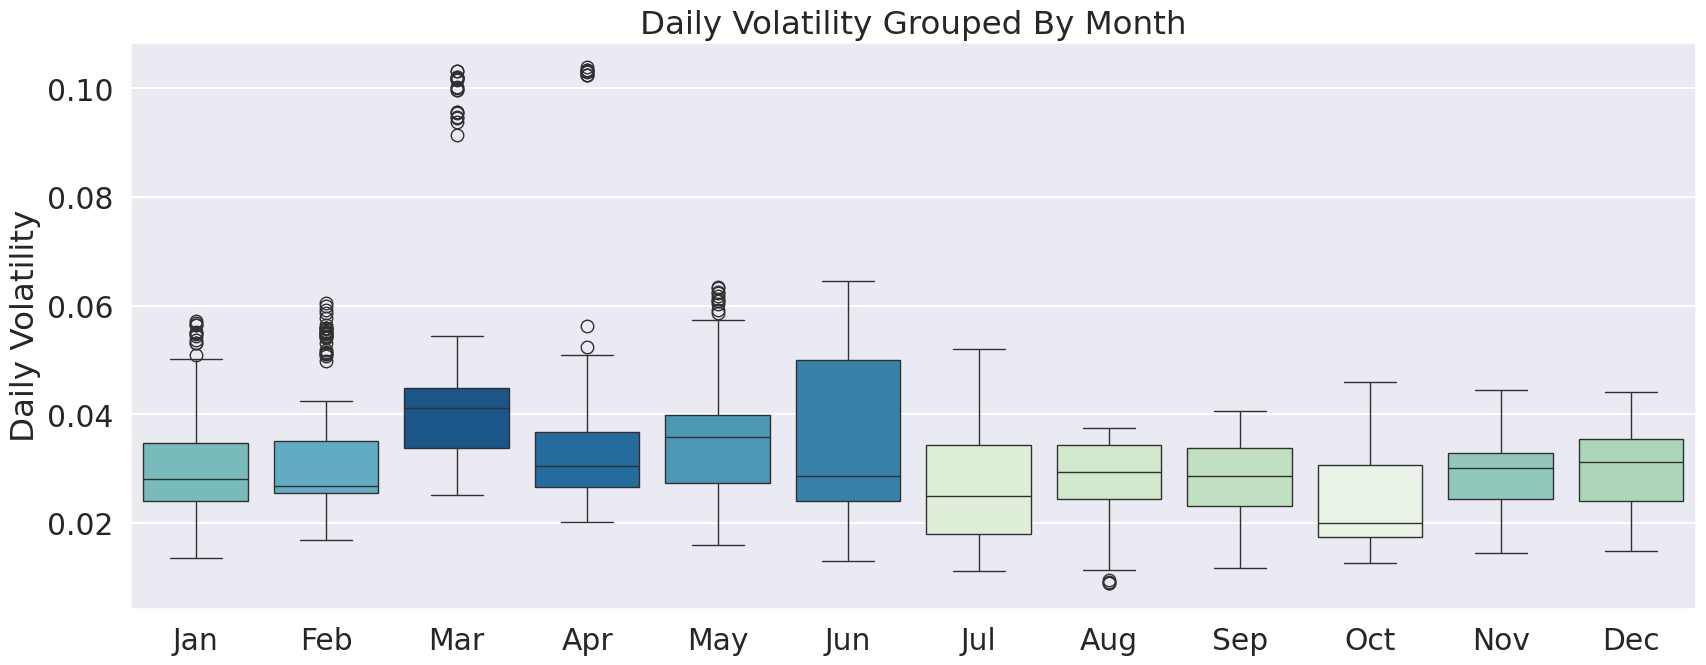

In [ ]:
# PRESORT MONTHS IN CHRONOLOGICAL ORDER
ordered_months = ['Jan', 'Feb', 'Mar', 'Apr','May','Jun',
                  'Jul', 'Aug','Sep', 'Oct', 'Nov', 'Dec']

# GROUP vol_current BY MONTH AND TAKE THE MEAN
data = df.groupby(by=[df.index.month_name()]).vol_current.mean()

# ABBREVIATE MONTH NAME
data.index = [x[:3] for x in data.index]

# SELECT PALETTE
pal = sns.color_palette("GnBu", len(data))

# SORT MONTH BY AVERAGE vol_current
rank = data.argsort().argsort().reindex(ordered_months)

with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(18,7))

    sns.boxplot(x=[x[:3] for x in df.index.month_name()],
                y=df.vol_current,
                palette=np.array(pal)[rank],
                order=ordered_months)
    ax.set(xlabel='',
           ylabel='Daily Volatility',
           title='Daily Volatility Grouped By Month')

In [ ]:
df.vol_current.sort_values(ascending=False)[:50]

Date
2020-04-06 00:00:00+00:00    0.103878
2020-04-03 00:00:00+00:00    0.103330
2020-04-02 00:00:00+00:00    0.103319
2020-03-30 00:00:00+00:00    0.103302
2020-03-31 00:00:00+00:00    0.103300
2020-04-01 00:00:00+00:00    0.103203
2020-04-05 00:00:00+00:00    0.103192
2020-04-04 00:00:00+00:00    0.103175
2020-04-10 00:00:00+00:00    0.103052
2020-04-07 00:00:00+00:00    0.102421
2020-04-09 00:00:00+00:00    0.102414
2020-04-08 00:00:00+00:00    0.102411
2020-03-29 00:00:00+00:00    0.102179
2020-03-24 00:00:00+00:00    0.102140
2020-03-25 00:00:00+00:00    0.102018
2020-03-23 00:00:00+00:00    0.101864
2020-03-26 00:00:00+00:00    0.101844
2020-03-28 00:00:00+00:00    0.101738
2020-03-27 00:00:00+00:00    0.101523
2020-03-22 00:00:00+00:00    0.100300
2020-03-19 00:00:00+00:00    0.100166
2020-03-20 00:00:00+00:00    0.099710
2020-03-21 00:00:00+00:00    0.099709
2020-03-17 00:00:00+00:00    0.095724
2020-03-18 00:00:00+00:00    0.095614
2020-03-16 00:00:00+00:00    0.095421
2020-03-15 00:00:00+00:00    0.094782
2020-03-14 00:00:00+00:00    0.094559
2020-03-13 00:00:00+00:00    0.093746
2020-03-12 00:00:00+00:00    0.091405
2021-06-10 00:00:00+00:00    0.064581
2021-06-09 00:00:00+00:00    0.064561
2021-05-24 00:00:00+00:00    0.063431
2021-05-25 00:00:00+00:00    0.063327
2021-05-29 00:00:00+00:00    0.062509
2021-05-28 00:00:00+00:00    0.062399
2021-06-13 00:00:00+00:00    0.062170
2021-06-02 00:00:00+00:00    0.061850
2021-06-07 00:00:00+00:00    0.061786
2021-06-08 00:00:00+00:00    0.061761
2021-05-31 00:00:00+00:00    0.061754
2021-06-01 00:00:00+00:00    0.061718
2021-06-14 00:00:00+00:00    0.061227
2021-06-15 00:00:00+00:00    0.061221
2021-05-30 00:00:00+00:00    0.061178
2021-06-03 00:00:00+00:00    0.060983
2021-05-27 00:00:00+00:00    0.060874
2021-05-26 00:00:00+00:00    0.060834
2021-06-16 00:00:00+00:00    0.060804
2021-06-05 00:00:00+00:00    0.060782
Name: vol_current, dtype: float64


Observation from the Realized Volatility Data (vol_current):
It can be observed that:

Volatility tends to remain higher during the months of March and April, where several spikes and fluctuations are consistently seen. This indicates periods of increased uncertainty or stronger price movements in these months historically.

The volatility in May and June appears relatively lower and more stable, showing fewer significant spikes compared to the earlier months.

Towards the months of July and August (which may include your final testing or forecasting window), volatility seems to calm down and stays at moderate to lower levels, suggesting a quieter market phase.

**daily Volatility Grouped by year ** **bold text**

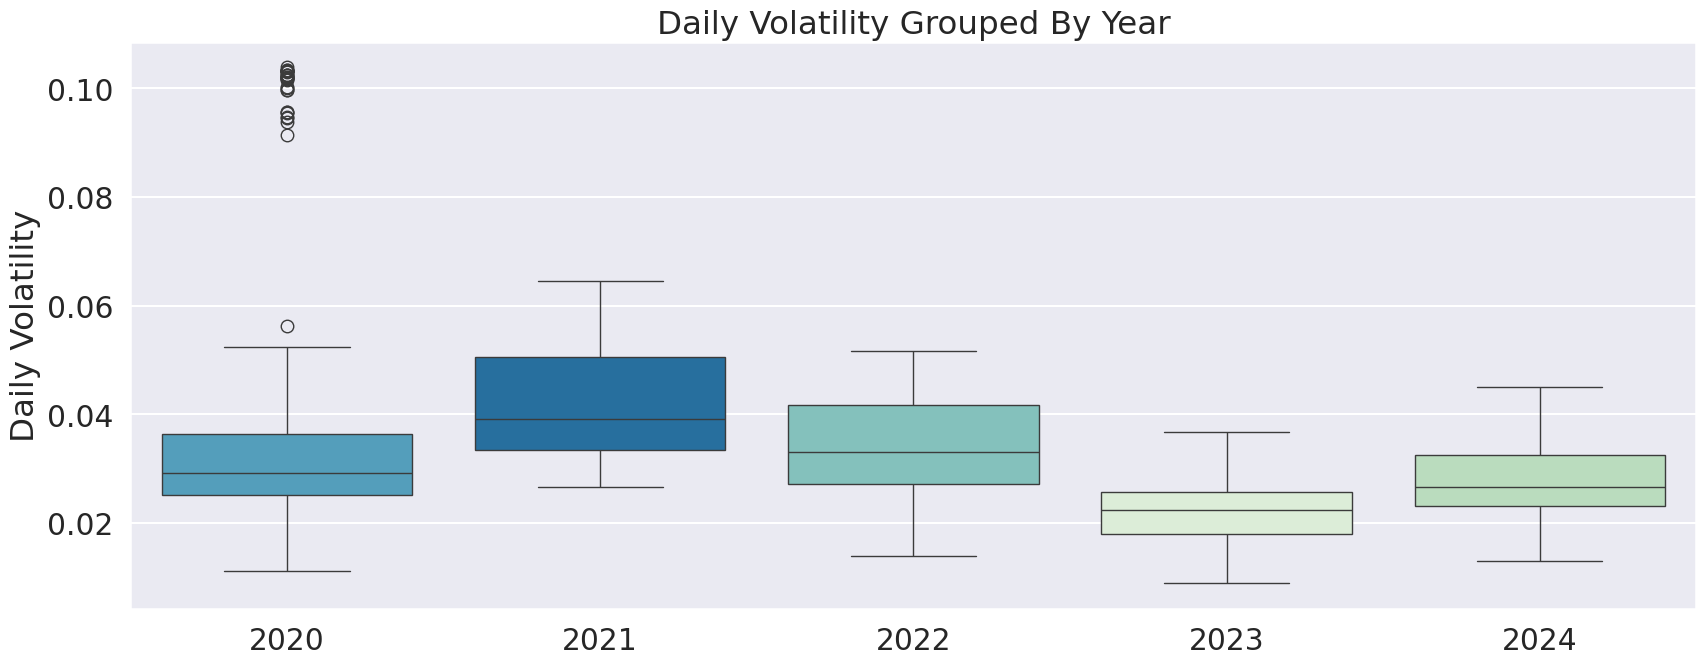

In [ ]:
# GROUP vol_current BY YEAR AND TAKE THE MEAN
data = df.groupby(by=[df.index.year]).vol_current.mean()

# SELECT PALETTE
pal = sns.color_palette("GnBu", len(data))

# SORT MONTH BY AVERAGE vol_current
rank = data.argsort().argsort()

with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(18,7))

    sns.boxplot(x=df.index.year,
                y=df.vol_current,
                palette=np.array(pal)[rank])
    ax.set(xlabel='',
           ylabel='Daily Volatility',
           title='Daily Volatility Grouped By Year')

2020 and 2021 show significantly higher volatility compared to the other years.

2020 has a noticeable number of large outliers (extreme high volatility days), likely due to market shocks or unusual price swings.

2021 has the highest median and widest spread of volatility values, indicating frequent fluctuations and instability throughout the year.

2022 exhibits moderate volatility levels, with reduced outliers compared to 2020 and 2021 but still a relatively wide spread of daily fluctuations.

2023 displays the lowest volatility overall, with both the median and the spread of daily volatility being much smaller.

This suggests a period of greater market stability or reduced trading activity during this year.

2024 shows a slight increase in volatility compared to 2023, but still remains lower than the early years (2020–2022).

However, the spread is wider than 2023, hinting at a few periods of elevated volatility.



**Daily Volatility Distribution**

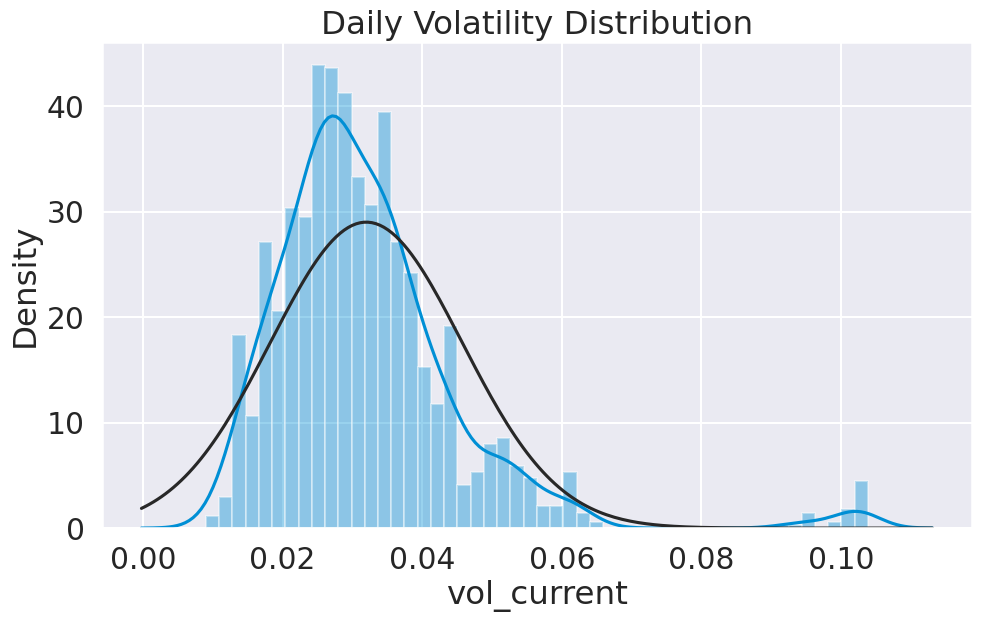

In [ ]:
with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(10,6))
    sns.distplot(df.vol_current, norm_hist=True, fit=stats.norm,
                bins=50, ax=ax)
    plt.title('Daily Volatility Distribution')

The distribution of daily realized volatility (vol_current) is lightly right-skewed (positively skewed), meaning that while most of the volatility values cluster around lower levels, there exists a thin tail extending toward higher volatility values on the right.

This indicates that most of the time, the market experiences relatively low volatility, but there are occasional days where volatility spikes significantly higher.

A right-skewed distribution typically shows the following relationship between its central tendency measures:

Mode < Median < Mean

The mode (the peak of the distribution) lies at the lower volatility values.

The median is slightly higher than the mode but still less than the mean.

The mean is pulled to the right by the influence of a few larger outliers (higher volatility days).

These characteristics suggest that while extreme volatility events are rare, they have a significant impact on the overall distribution of the realized volatility.

In [ ]:
from scipy.stats import skew, kurtosis

# Assuming 'df' is your DataFrame and it contains a column named 'log_returns'
log_return_series = df['log_returns'].dropna()

# Calculate skewness
skewness = skew(log_return_series)

# Calculate kurtosis
kurt = kurtosis(log_return_series, fisher=True)  # Set fisher=True to get excess kurtosis

print(f"Skewness: {skewness:.4f}")
print(f"Kurtosis: {kurt:.4f}")


Skewness: -1.4159
Kurtosis: 21.5380


**Returns/Log Returns Stationarity Checking**

In [ ]:
from statsmodels.tsa.stattools import adfuller
# LOG RETURNS
adfuller_results = adfuller(df.log_returns.dropna())

print(f'ADF Statistic: {adfuller_results[0]}')
print(f'p-value: {adfuller_results[1]}')
print('Critical Values:')
for key, value in adfuller_results[4].items():
    print(f'{key}: {value:.4f}')

ADF Statistic: -13.746014811023247
p-value: 1.0722338153914642e-25
Critical Values:
1%: -3.4340
5%: -2.8632
10%: -2.5676


In [ ]:
# RETURNS
adfuller_results = adfuller(df.returns.dropna())

print(f'ADF Statistic: {adfuller_results[0]}')
print(f'p-value: {adfuller_results[1]}')
print('Critical Values:')
for key, value in adfuller_results[4].items():
    print(f'{key}: {value:.4f}')

ADF Statistic: -13.72625290905343
p-value: 1.162617860229981e-25
Critical Values:
1%: -3.4340
5%: -2.8632
10%: -2.5676


Using a significance level (α) of 0.05, the p-values for both Returns and Log Returns are much smaller than 0.05, indicating strong evidence to reject the null hypothesis (which assumes the presence of a unit root or non-stationarity).

This means that:

Both Returns and Log Returns are stationary time series —
they are not dependent on time or trend, and their statistical properties (mean, variance) remain constant over time.

This conclusion confirms that the dataset is appropriate for applying models like GARCH and other time-series forecasting techniques, which require stationarity.



# Train validation Test Splits

In [ ]:
test_size = 30
val_size = 365

# CONVERT TO INDICES
split_time_1 = len(df) - (val_size + test_size)
split_time_2 = len(df) - test_size

# GET CORRESPONDING DATETIME INDICES FOR EACH SET
train_idx = df.index[:split_time_1]
val_idx = df.index[split_time_1:split_time_2]
test_idx = df.index[split_time_2:]

In [ ]:
print(f'TRAINING \tFrom: {train_idx[0]} \tto: {train_idx[-1]} \t{len(train_idx)} days')
print(f'VALIDATION \tFrom: {val_idx[0]} \tto: {val_idx[-1]} \t{len(val_idx)} days')
print(f'TEST \t\tFrom: {test_idx[0]} \tto: {test_idx[-1]} \t{len(test_idx)} days')

TRAINING 	From: 2020-01-31 00:00:00+00:00 	to: 2023-11-24 00:00:00+00:00 	1394 days
VALIDATION 	From: 2023-11-25 00:00:00+00:00 	to: 2024-11-23 00:00:00+00:00 	365 days
TEST 		From: 2024-11-24 00:00:00+00:00 	to: 2024-12-23 00:00:00+00:00 	30 days


The target variable in this project is vol_future, representing the average daily realized volatility of the next n_future days (7 days) from the current time step.
The realized volatility is computed using a rolling INTERVAL_WINDOW of 30 days.
For each current time step t, the volatility prediction targets the smoothed volatility behavior over the interval t + n_future - INTERVAL_WINDOW to t + n_future, ensuring stable and robust forecasting.



In [ ]:
# SPLIT FORWARD VOLATILITY INTO 3 PARTS
# (this would be the target)
y_train = df.vol_future[train_idx]
y_val = df.vol_future[val_idx]
y_test = df.vol_future[test_idx]

In [ ]:
# SPLIT CURRENT DAILY REALIZED VOLATILITY INTO 3 PARTS
# (this would be the input for baseline, random walk, and NN models)
x_train = df.vol_current[train_idx]
x_val = df.vol_current[val_idx]
x_test = df.vol_current[test_idx]

In [ ]:
# SPLIT RETURNS INTO 3 PARTS
# (this would be the input for GARCH models)
r_train = df.returns[train_idx]
r_val = df.returns[val_idx]
r_test = df.returns[test_idx]

In [ ]:
# SPLIT LOG RETURNS INTO 3 PARTS
# (mostly for visualization)
lr_train = df.log_returns[train_idx]
lr_val = df.log_returns[val_idx]
lr_test = df.log_returns[test_idx]

In [ ]:
y_train.describe()

count    1394.000000
mean        0.033298
std         0.014970
min         0.009005
25%         0.023954
50%         0.031075
75%         0.039174
max         0.103878
Name: vol_future, dtype: float64

In [ ]:
x_train.describe()

count    1394.000000
mean        0.033325
std         0.014955
min         0.009005
25%         0.024144
50%         0.031075
75%         0.039174
max         0.103878
Name: vol_current, dtype: float64

# Data Preprocessing

1. Feature Normalization


As I am going to build various types of models based on different algorithms using different types of inputs, it would be better to normalize the volatilities to standardize the predictions generated by different models. After experimenting with different Scalers, I decided to use MinMaxScaler as it yielded best results overall.

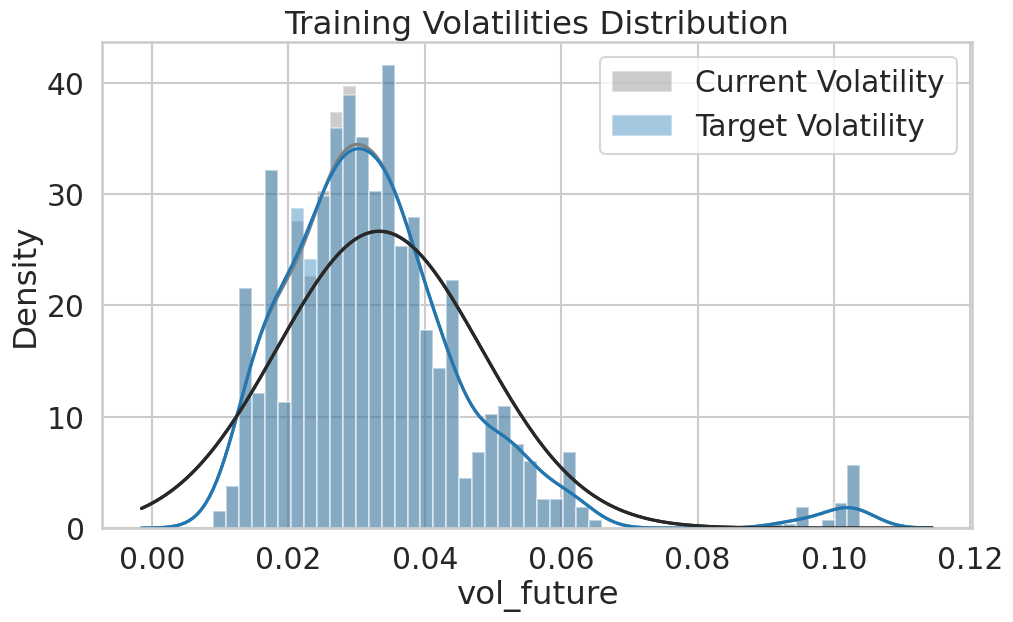

In [ ]:
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(10,6))
    sns.distplot(x_train, norm_hist=True, fit=stats.norm,
                 color='gray',
                 bins=50, ax=ax, label='Current Volatility')
    sns.distplot(y_train, norm_hist=True, fit=stats.norm,
                 color='tab:blue',
                 bins=50, ax=ax, label='Target Volatility')
    plt.title('Training Volatilities Distribution')
    plt.legend()

In [ ]:
def transform_volatility_to_scaler(scaler, tf_series):
    '''
    Transform a series to a fitted scaler
    '''
    idx = tf_series.index
    output = pd.Series(scaler.transform(tf_series.values.reshape(-1,1))[:,0],
                       index=idx)
    return output

In [ ]:
# INITIATE SCALER
scaler_vol = MinMaxScaler()

# FIT SCALER TO CURRENT VOLATILITY IN TRAINING SET
scaler_vol = scaler_vol.fit(x_train.values.reshape(-1,1))

In [ ]:
# TRANSFORM TRAINING CURRENT & FUTURE VOLATILITIES
x_train_scaled = transform_volatility_to_scaler(scaler_vol, x_train)
y_train_scaled = transform_volatility_to_scaler(scaler_vol, y_train)

# TRANSFORMING VALIDATION CURRENT & FUTURE VOLATILITIES
x_val_scaled = transform_volatility_to_scaler(scaler_vol, x_val)
y_val_scaled = transform_volatility_to_scaler(scaler_vol, y_val)

# TRANSFORMING TEST CURRENT & FUTURE VOLATILITIES
x_test_scaled = transform_volatility_to_scaler(scaler_vol, x_test)
y_test_scaled = transform_volatility_to_scaler(scaler_vol, y_test)

In [ ]:
x_train.head(10)

Date
2020-01-31 00:00:00+00:00    0.029473
2020-02-01 00:00:00+00:00    0.028944
2020-02-02 00:00:00+00:00    0.027421
2020-02-03 00:00:00+00:00    0.027389
2020-02-04 00:00:00+00:00    0.027483
2020-02-05 00:00:00+00:00    0.027416
2020-02-06 00:00:00+00:00    0.025924
2020-02-07 00:00:00+00:00    0.025884
2020-02-08 00:00:00+00:00    0.025492
2020-02-09 00:00:00+00:00    0.025049
Name: vol_current, dtype: float64

In [ ]:
y_train.head(10)

Date
2020-01-31 00:00:00+00:00    0.025884
2020-02-01 00:00:00+00:00    0.025492
2020-02-02 00:00:00+00:00    0.025049
2020-02-03 00:00:00+00:00    0.025339
2020-02-04 00:00:00+00:00    0.025920
2020-02-05 00:00:00+00:00    0.025985
2020-02-06 00:00:00+00:00    0.021337
2020-02-07 00:00:00+00:00    0.021406
2020-02-08 00:00:00+00:00    0.022705
2020-02-09 00:00:00+00:00    0.022306
Name: vol_future, dtype: float64

In [ ]:
x_train_scaled.head(10)

Date
2020-01-31 00:00:00+00:00    0.215742
2020-02-01 00:00:00+00:00    0.210167
2020-02-02 00:00:00+00:00    0.194108
2020-02-03 00:00:00+00:00    0.193778
2020-02-04 00:00:00+00:00    0.194762
2020-02-05 00:00:00+00:00    0.194062
2020-02-06 00:00:00+00:00    0.178335
2020-02-07 00:00:00+00:00    0.177910
2020-02-08 00:00:00+00:00    0.173780
2020-02-09 00:00:00+00:00    0.169103
dtype: float64

In [ ]:
y_train_scaled.head(10)

Date
2020-01-31 00:00:00+00:00    0.177910
2020-02-01 00:00:00+00:00    0.173780
2020-02-02 00:00:00+00:00    0.169103
2020-02-03 00:00:00+00:00    0.172166
2020-02-04 00:00:00+00:00    0.178293
2020-02-05 00:00:00+00:00    0.178970
2020-02-06 00:00:00+00:00    0.129986
2020-02-07 00:00:00+00:00    0.130710
2020-02-08 00:00:00+00:00    0.144401
2020-02-09 00:00:00+00:00    0.140201
dtype: float64

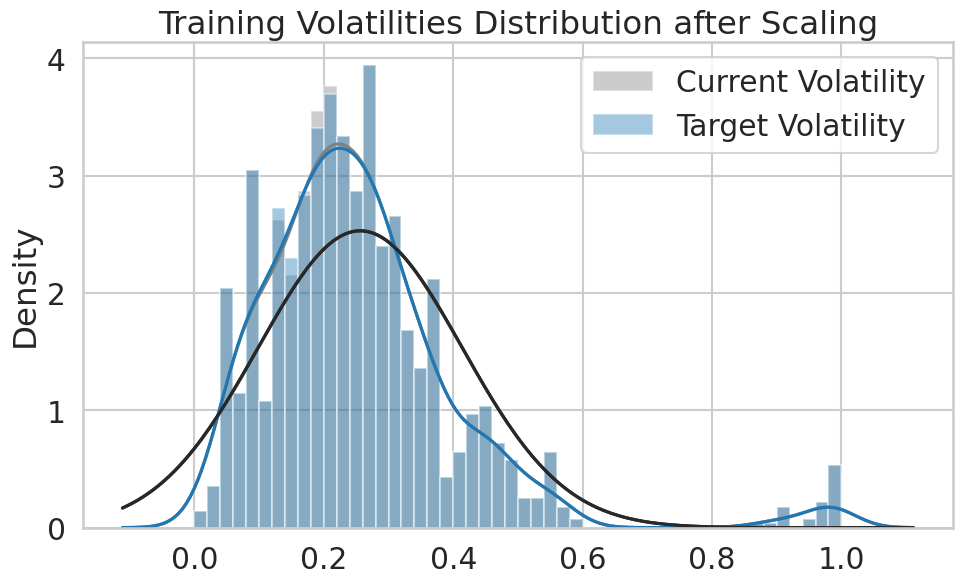

In [ ]:
# PLOTTING VOLATILITIES AFTER SCALING
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(10,6))
    sns.distplot(x_train_scaled, norm_hist=True, fit=stats.norm,
                 color='gray',
                 bins=50, ax=ax, label='Current Volatility')
    sns.distplot(y_train_scaled, norm_hist=True, fit=stats.norm,
                 color='tab:blue',
                 bins=50, ax=ax, label='Target Volatility')
    plt.title('Training Volatilities Distribution after Scaling')
    plt.legend()

**2. Train-Validation-Test Visualization**

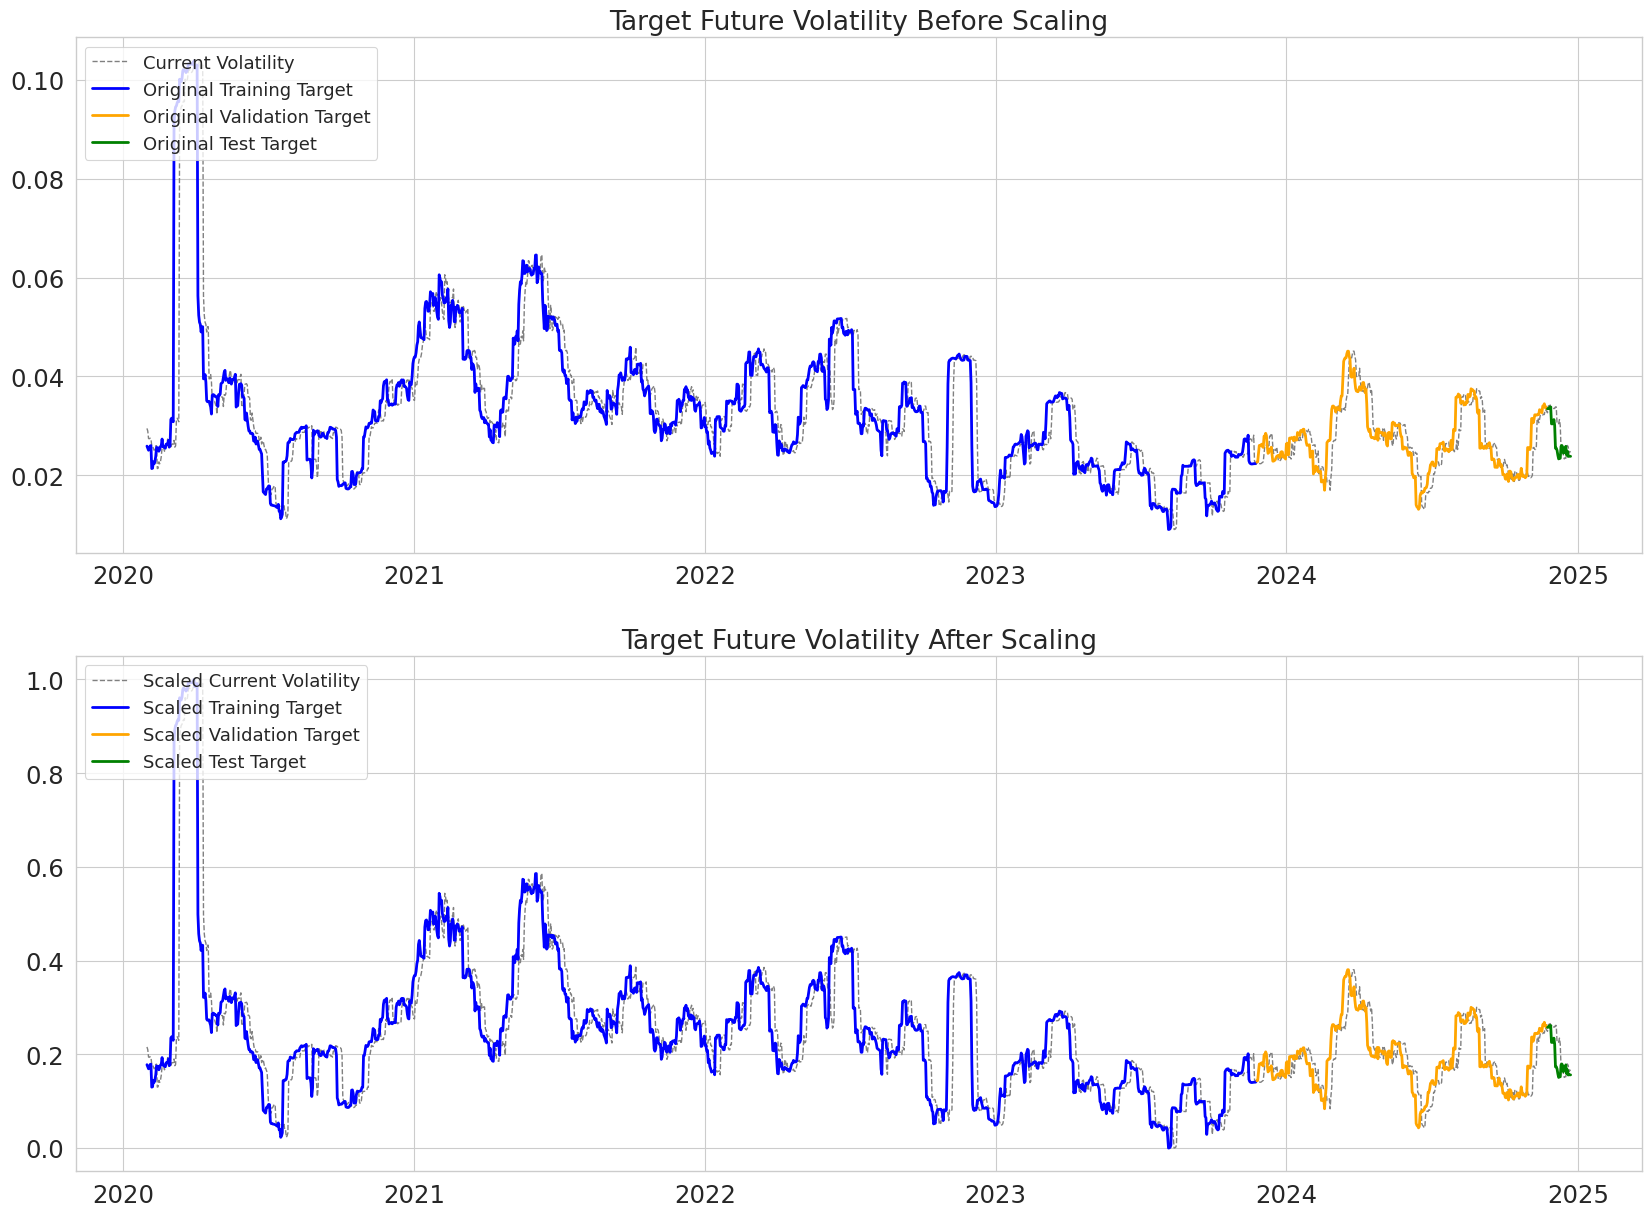

In [ ]:
sns.set_context("paper", font_scale=2)

# VISUALIZE TRAIN/VALIDATION/TEST vol_future BEFORE & AFTER TRAINING
with sns.axes_style("whitegrid"):
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(18,14))

    ax1.plot(df.vol_current, lw=1, color='gray', ls='--',
                label='Current Volatility')
    ax1.plot(y_train, color='blue', label='Original Training Target', lw=2)
    ax1.plot(y_val, color='orange', label='Original Validation Target', lw=2)
    ax1.plot(y_test, color='green', label='Original Test Target', lw=2)

    ax1.title.set_text('Target Future Volatility Before Scaling')

    ax2.plot(transform_volatility_to_scaler(scaler_vol, df.vol_current),
                lw=1, color='gray', ls='--',
                label='Scaled Current Volatility')
    ax2.plot(y_train_scaled, color='blue', label='Scaled Training Target', lw=2)
    ax2.plot(y_val_scaled, color='orange', label='Scaled Validation Target', lw=2)
    ax2.plot(y_test_scaled, color='green', label='Scaled Test Target', lw=2)

    ax2.title.set_text('Target Future Volatility After Scaling')

    ax1.legend(loc='upper left', prop={'size': 13}, frameon=True)
    ax2.legend(loc='upper left', prop={'size': 13}, frameon=True)

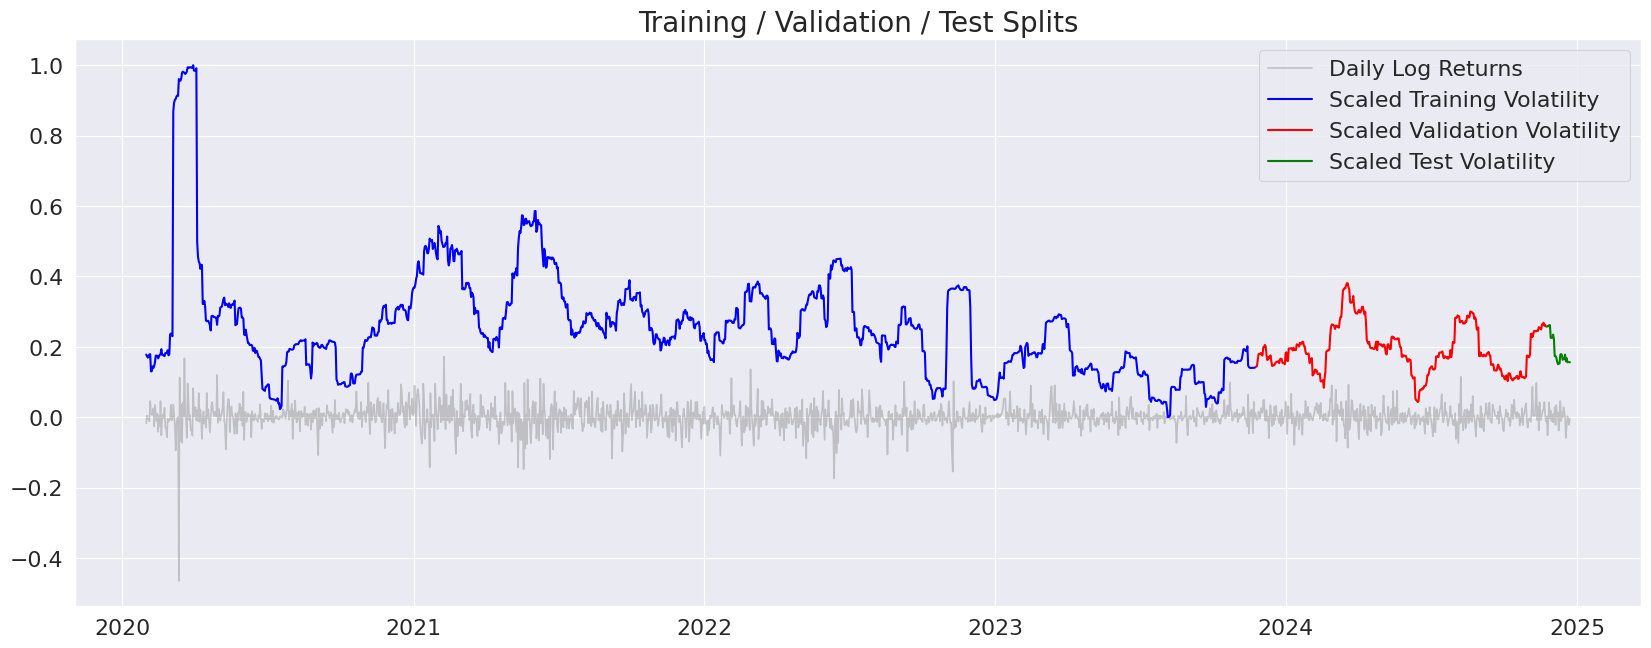

In [ ]:
sns.set_context("paper", font_scale=1.8)
with sns.axes_style("darkgrid"):
    plt.figure(figsize=(18,7))

    plt.plot(df.log_returns, color='gray', label='Daily Log Returns', alpha=0.4)

    plt.plot(y_train_scaled, color='blue',
             label='Scaled Training Volatility', lw=1.5)
    plt.plot(y_val_scaled, color='red',
             label='Scaled Validation Volatility', lw=1.5)
    plt.plot(y_test_scaled, color='green',
             label='Scaled Test Volatility', lw=1.5)

    plt.plot()
    plt.title('Training / Validation / Test Splits', fontsize=20)
    plt.legend(frameon=True)

# Modeling


In [ ]:
# DEFINE ROOT MEAN SQUARED PERCENTAGE ERROR FUNCTION
def RMSPE(y_true, y_pred):
    """
    Compute Root Mean Squared Percentage Error between 2 arrays
    """
    output = np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))
    return output

In [ ]:
# DEFINE ROOT MEAN SQUARED ERROR FUNCTION
def RMSE(y_true, y_pred):
    """
    Compute Root Mean Squared Error between 2 arrays
    """
    output = np.sqrt(mse(y_true, y_pred))
    return output

In [ ]:
# INITIATE A DATAFRAME FOR MODEL PERFORMANCE TRACKING & COMPARISON
perf_df = pd.DataFrame(columns=['Model', 'Validation RMSPE', 'Validation RMSE'])

In [ ]:
# A FUNCTION THAT LOGS MODEL NAME, RMSE AND RMPSE INTO perf_df
# FOR EASY COMPARISON LATER
def log_perf(y_true, y_pred, model_name):
    perf_df.loc[len(perf_df.index)] = [model_name,
                                       RMSPE(y_true, y_pred),
                                       RMSE(y_true, y_pred)]
    return perf_df


In [ ]:
# PLOTTING MODEL PREDICTIONS VS. TARGET VALUES
def viz_model(y_true, y_pred, model_name):
    sns.set_context("paper", font_scale=1.7)
    plt.rcParams["axes.grid"] = False

    with sns.axes_style("whitegrid"):
        plt.figure(figsize=(18,7))
        plt.plot(x_val_scaled, color='gray',  ls=':',
                label=f"Scaled Current Daily Volatility")

        plt.plot(y_true, color='blue', lw=2,
                label=f"Target Volatility")
        plt.plot(y_pred, color='orange', lw=2.5,
                label=f'Forecasted Volatility')

        # plt.plot(lr_val, color='gray', alpha=0.4,
        #         label='Daily Log Returns')

        plt.title(f'{model_name} \non Validation Data')
        plt.legend(loc='best', frameon=True)

# 2. Baseline Model
1. Mean Baseline

In [ ]:
# CALCULATE THE MEAN OF SCALED TRAINING DATA
mean_train_vol = x_train_scaled.mean()
mean_train_vol

np.float64(0.2563457506119477)

In [ ]:
# CREATE SERIES OF PREDICTIONS FOR BASELINE MODEL ON VALIDATION SET
baseline_preds = np.ones(len(val_idx)) * mean_train_vol
baseline_preds = pd.Series(baseline_preds, index=lr_val.index)

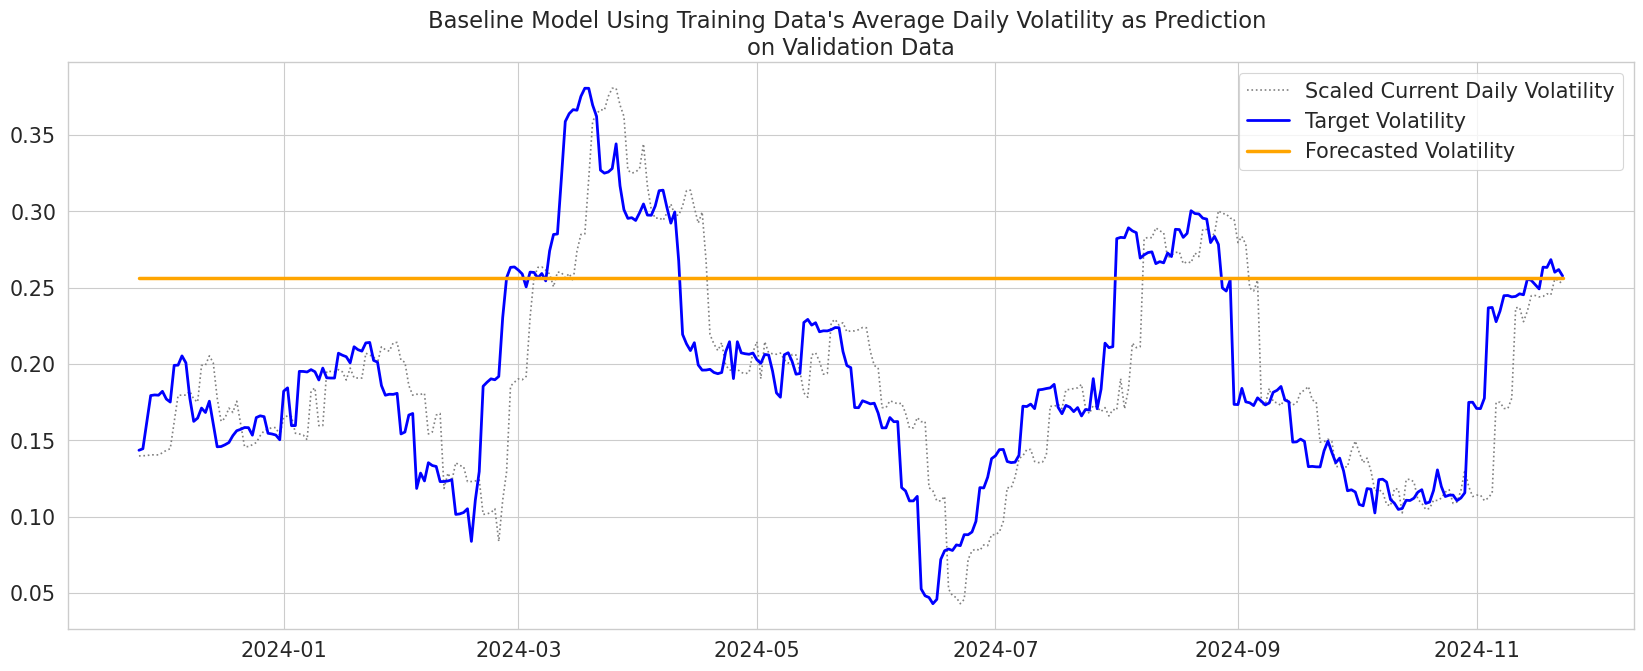

In [ ]:
viz_model(y_val_scaled, baseline_preds,
          f"Baseline Model Using Training Data's Average Daily Volatility as Prediction")

In [ ]:
log_perf(y_val_scaled, baseline_preds, 'Mean Baseline')

Model  Validation RMSPE  Validation RMSE
0  Mean Baseline          0.878159         0.092369

# 2.2. Random Walk Naive Forecasting


In [ ]:

# USING THE PREVIOUS n_future DAY'S VOLATILITY
random_walk_preds = x_val_scaled

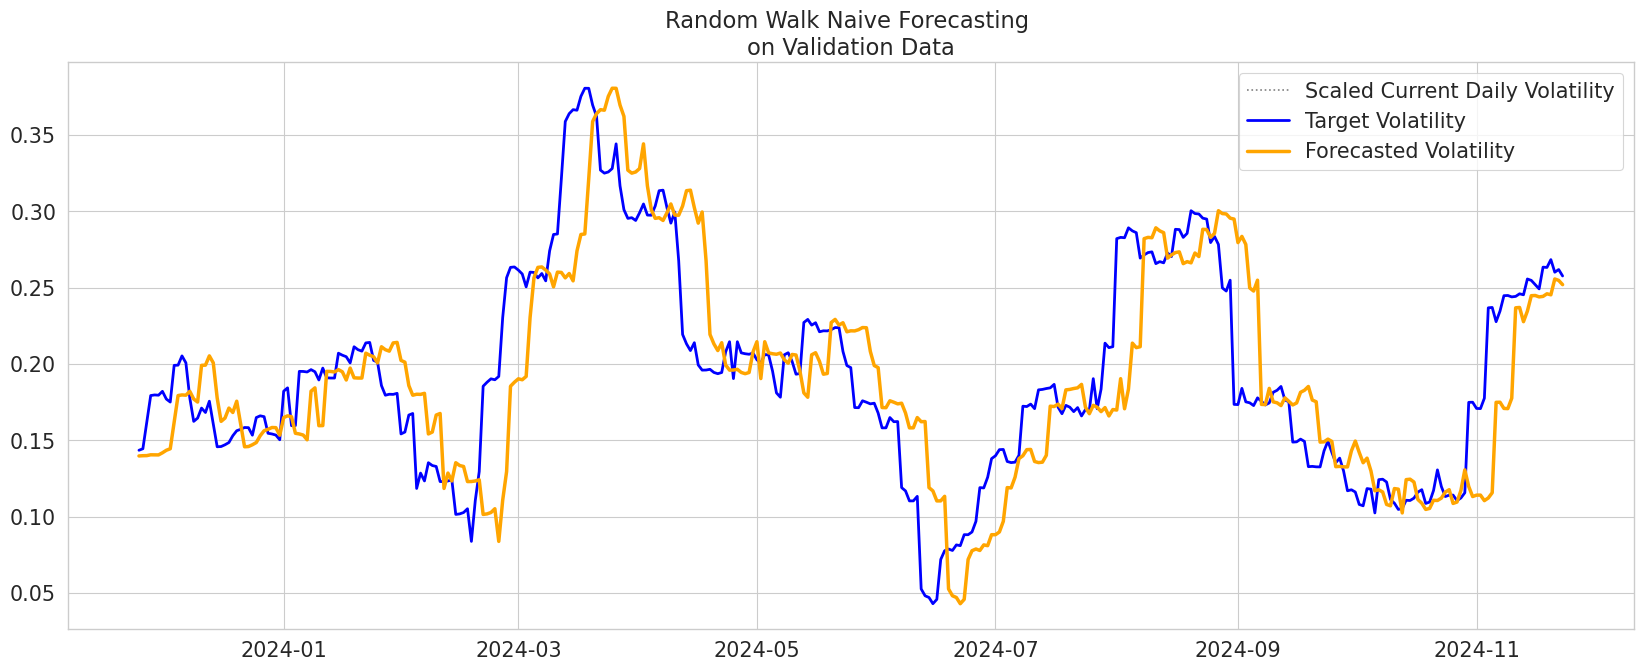

In [ ]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, random_walk_preds, 'Random Walk Naive Forecasting')

In [ ]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, random_walk_preds,
         'Random Walk Naive Forecasting')

Model  Validation RMSPE  Validation RMSE
0                  Mean Baseline          0.878159         0.092369
1  Random Walk Naive Forecasting          0.306851         0.042442

# 3. GARCH MODEL


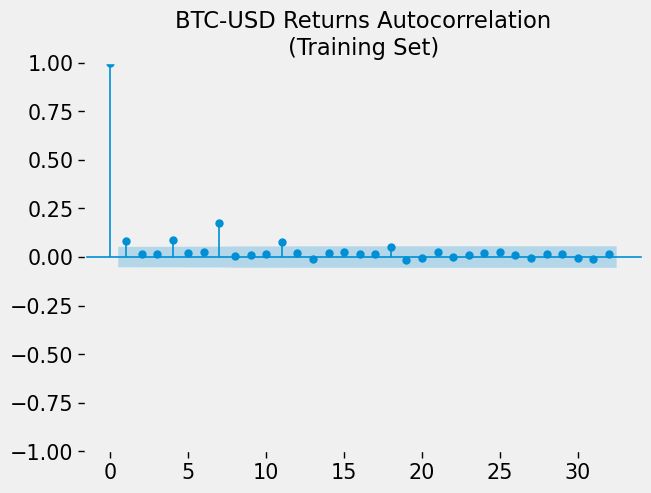

In [ ]:
# VISUALIZE AUTOCORRELATION OF SQUARED RETURNS
plot_acf(r_train**2,
          title=f'{tckr.upper()} Returns Autocorrelation\n(Training Set)');

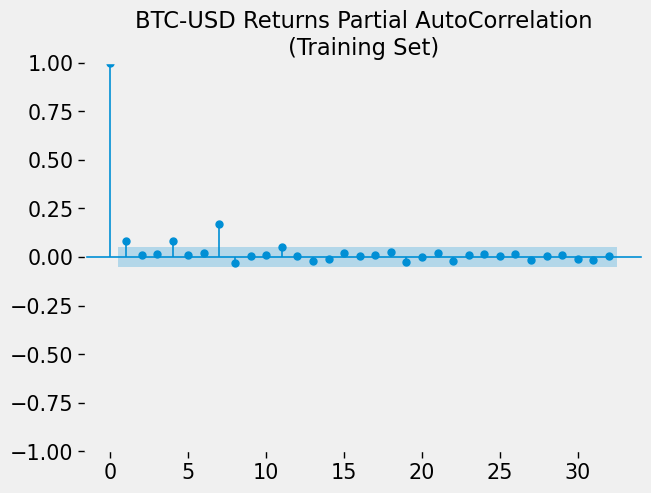

In [ ]:
# VISUALIZE PARTIAL AUTOCORRELATION OF SQUARED RETURNS
plot_pacf(r_train**2,
          title=f'{tckr.upper()} Returns Partial AutoCorrelation\n(Training Set)');

In [ ]:
!pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 12.1 MB/s eta 0:00:00


In [ ]:
from arch import arch_model

In [ ]:
# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

gm_1 = arch_model(r_train, p=7, q=7)
result_1 = gm_1.fit(disp='off')
print()
print(result_1.summary())


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3616.83
Distribution:                  Normal   AIC:                           7265.67
Method:            Maximum Likelihood   BIC:                           7349.51
                                        No. Observations:                 1394
Date:                Wed, May 07 2025   Df Residuals:                     1393
Time:                        14:45:34   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.1727      0.157      1.101      0.271 [ -0.135,  0.4

In [ ]:
gm_1 = arch_model(r_train, vol='GARCH', p=1, q=1)
result_1 = gm_1.fit(disp='off')
print()
print(result_1.summary())


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3661.42
Distribution:                  Normal   AIC:                           7330.84
Method:            Maximum Likelihood   BIC:                           7351.80
                                        No. Observations:                 1394
Date:                Wed, May 07 2025   Df Residuals:                     1393
Time:                        14:45:51   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.2066  8.702e-02      2.374  1.762e-02 [3.599e-

In [ ]:
def scale_tf_cond_vol(model_result):
    '''
    Scale & Transform Conditional Volatility
    Estimated by GARCH Models
    '''
    # OBTAIN ESTIMATED CONDITIONAL VOLATILITY FROM MODEL RESULT
    cond_vol = model_result.conditional_volatility

    # INITIATE SCALER
    scaler = MinMaxScaler()

    # FIT SCALER TO MODEL'S ESTIMATED CONDITIONAL VOLATILITY
    scaler = scaler.fit(cond_vol.values.reshape(-1,1))

    scaled_cond_vol = transform_volatility_to_scaler(scaler, cond_vol)
    return scaler, scaled_cond_vol

In [ ]:
# GET VOLATILITY SCALER & SCALED CONDITIONAL VOLATILITY FROM MODEL RESULT
scaler_garch, scaled_cond_vol = scale_tf_cond_vol(result_1)

In [ ]:
# VISUALIZE MODEL'S ESTIMATED CONDITIONAL VOLATILITY
# WITH SCALED vol_current CALCULATED ABOVE
def viz_cond_vol(cond_vol_series, model_name):
    with sns.axes_style("darkgrid"):
        fig, ax = plt.subplots(figsize=(18,7))

        ax.plot(x_train_scaled, color='blue', lw=2,
                label=f'Scaled {INTERVAL_WINDOW}-Day Interval Daily Realized Volatility')
        ax.plot(cond_vol_series, color='orange', lw=2,
                label=f'Scaled {model_name} Estimated Conditional Volatility')
        ax.set_title('Training Set')
        plt.legend()
        plt.show();

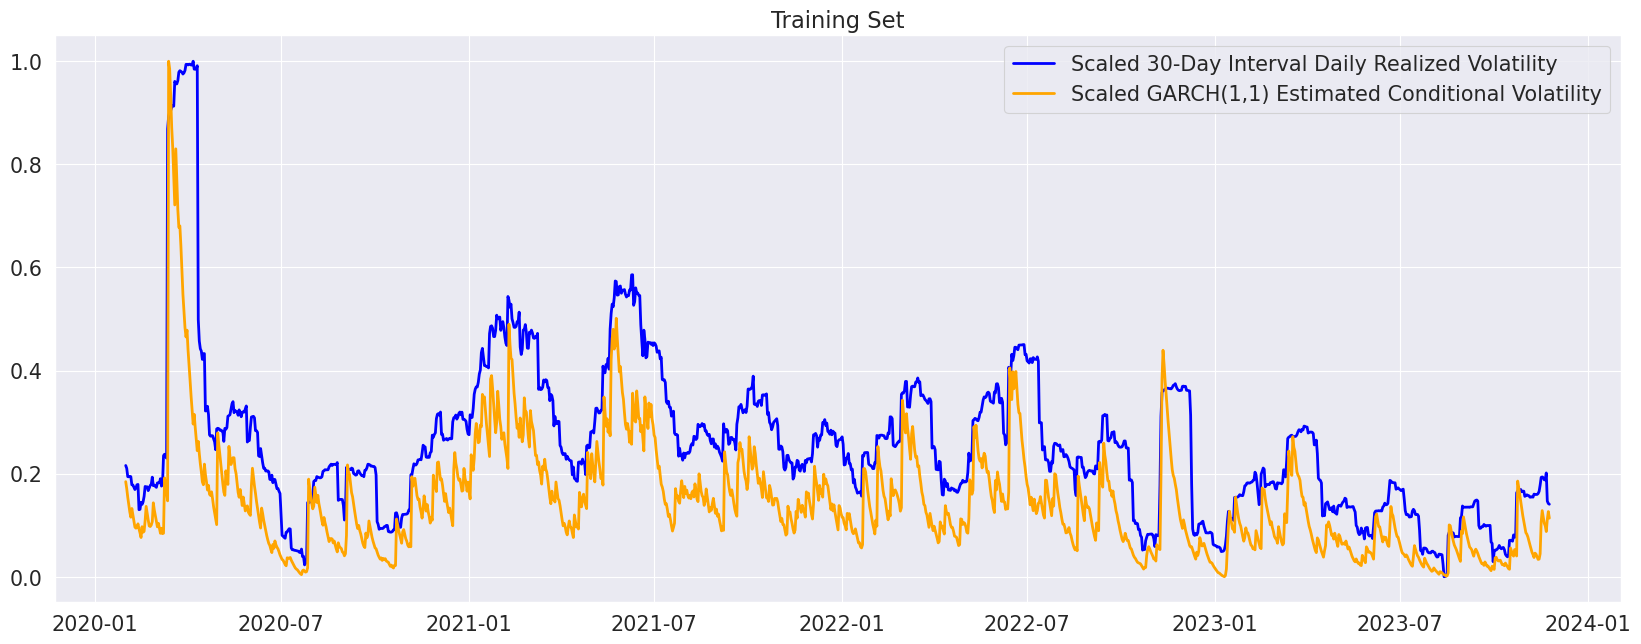

In [ ]:
viz_cond_vol(scaled_cond_vol, 'GARCH(1,1)')


3.1.1. Analytical-based Forecasting


In [ ]:
# ONE STEP EXPANDING WINDOW FORECAST
# INITIALIZING rolling_forecast
rolling_forecasts = []
idx = df.index

# ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
for i in range(len(val_idx)):
    # GET THE DATA AT ALL PREVIOUS TIME STEPS
    idx = val_idx[i]
    train = df.returns[:idx]

    # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
    model = arch_model(train, vol='GARCH', p=1, q=1,
                       dist='normal')
    model_fit = model.fit(disp='off')

    # MAKE PREDICTION n_future DAYS OUT
    vaR = model_fit.forecast(horizon=n_future,
                             reindex=False).variance.values
    # GET THE SQRT OF AVERAGE n_future DAYS VARIANCE
    pred = np.sqrt(np.mean(vaR))

    # APPEND TO rolling_forecasts LIST
    rolling_forecasts.append(pred)

gm_1_preds = pd.Series(rolling_forecasts, index=val_idx)

In [ ]:
# TRANSFORM PREDICTIONS USING FITTED SCALER
gm_1_preds_scaled = transform_volatility_to_scaler(scaler_garch, gm_1_preds)

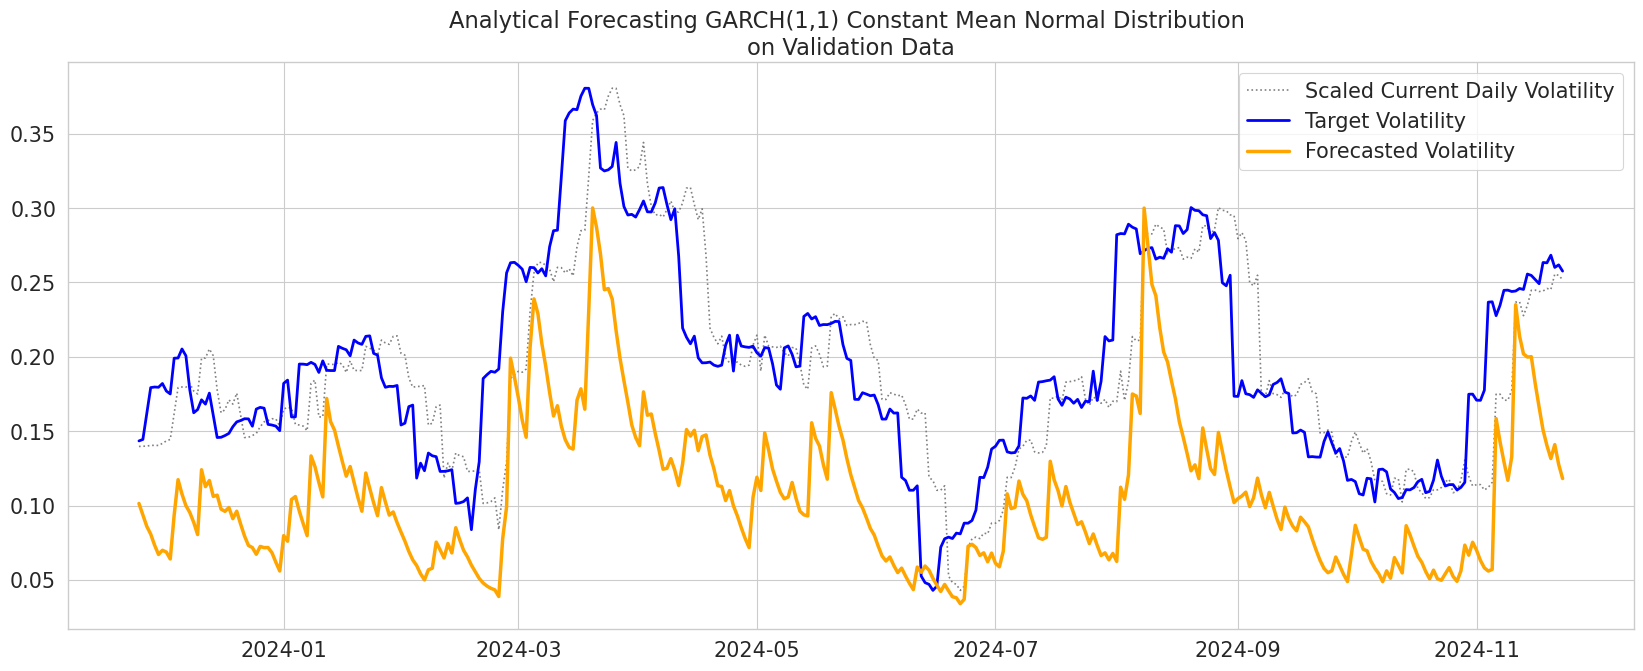

In [ ]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, gm_1_preds_scaled,
          'Analytical Forecasting GARCH(1,1) Constant Mean Normal Distribution')

In [ ]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, gm_1_preds_scaled,
         'GARCH(1,1), Constant Mean, Normal Dist')

Model  Validation RMSPE  Validation RMSE
0                           Mean Baseline          0.878159         0.092369
1           Random Walk Naive Forecasting          0.306851         0.042442
2  GARCH(1,1), Constant Mean, Normal Dist          0.467404         0.095364

Next, I would inspect the estimated residuals from this first GARCH model.



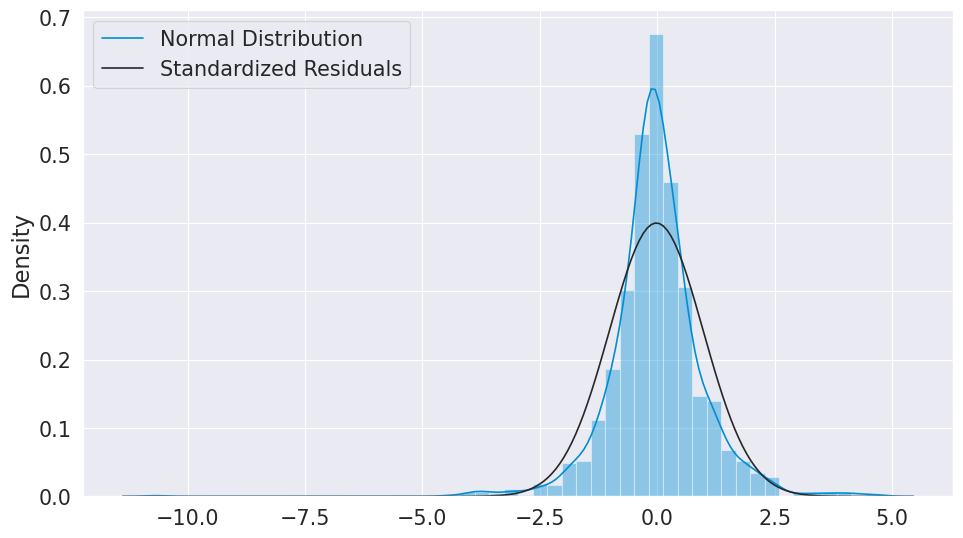

In [ ]:
# INSPECTING THE RESIDUALS
gm_resid = result_1.resid
gm_std = result_1.conditional_volatility

# STANDARDIZING RESIDUALS
gm_std_resid = gm_resid / gm_std

# VISUALIZING STANDARDIZED RESIDUALS VS. A NORMAL DISTRIBUTION
with sns.axes_style("darkgrid"):
    plt.figure(figsize=(10,6))
    sns.distplot(gm_std_resid, norm_hist=True, fit=stats.norm, bins=50)
    plt.legend(('Normal Distribution', 'Standardized Residuals'))
    plt.show();

# 3.2. GARCH Model with Asymmetric Shocks Responses
:

In [ ]:
# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

gjr_gm = arch_model(r_train, p=1, q=1, o=1,
                    vol='GARCH', dist='skewt')
result_2 = gjr_gm.fit(disp='off')
print(result_2.summary())

                         Constant Mean - GJR-GARCH Model Results                         
Dep. Variable:                           returns   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                             GJR-GARCH   Log-Likelihood:               -3478.18
Distribution:      Standardized Skew Student's t   AIC:                           6970.36
Method:                       Maximum Likelihood   BIC:                           7007.04
                                                   No. Observations:                 1394
Date:                           Wed, May 07 2025   Df Residuals:                     1393
Time:                                   14:46:25   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
--------------------------------------

In [ ]:
# GET VOLATILITY SCALER & SCALED CONDITIONAL VOLATILITY FROM MODEL RESULT
scaler_gjr, scaled_gjr_cond_vol = scale_tf_cond_vol(result_2)

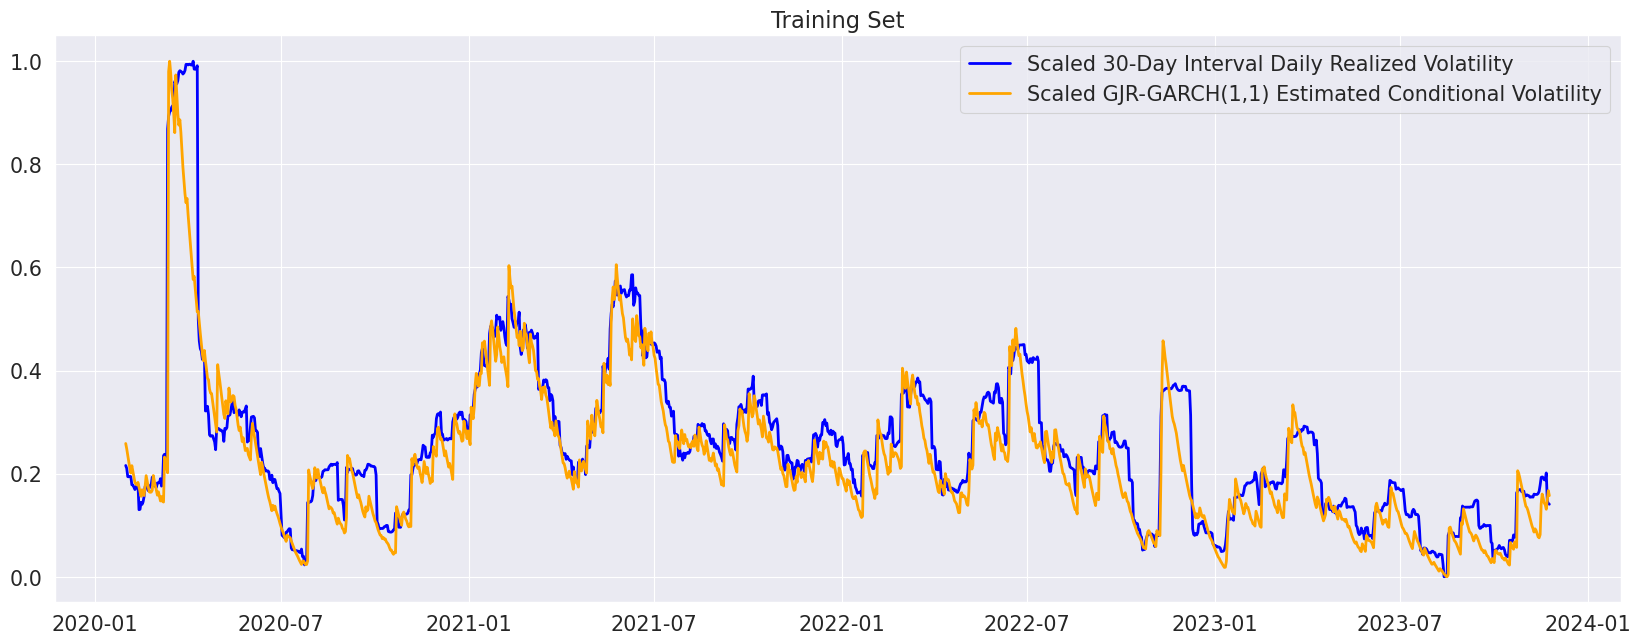

In [ ]:
viz_cond_vol(scaled_gjr_cond_vol, 'GJR-GARCH(1,1)')

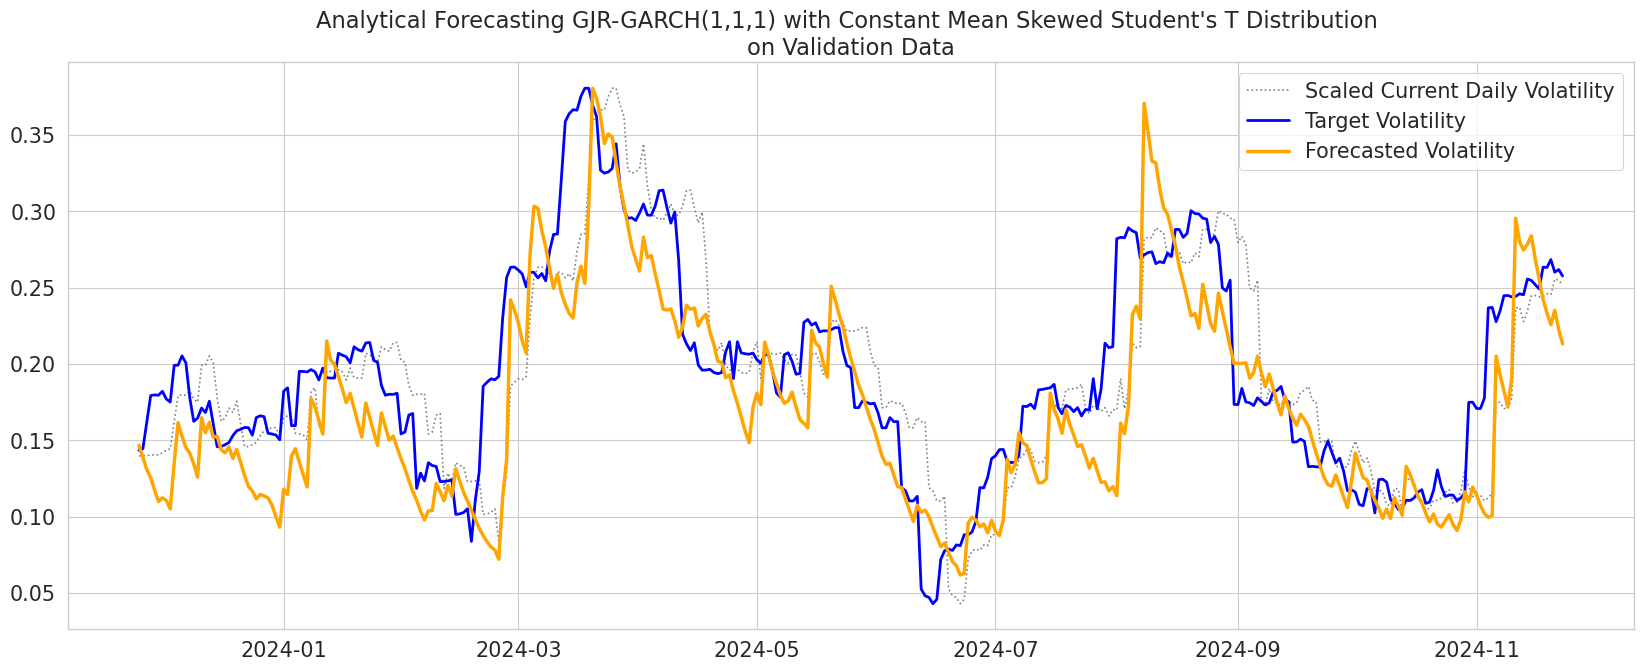

In [ ]:
# ROLLING WINDOW FORECAST
# INITIALIZING rolling_forecasts VALUES LIST
rolling_forecasts = []

# ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
for i in range(len(val_idx)):
    # GET THE DATA AT ALL PREVIOUS TIME STEPS
    idx = val_idx[i]
    train = df.returns[:idx].dropna()

    # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
    model = arch_model(train, p=1, q=1, o=1,
                       vol='GARCH', dist='skewt')
    model_fit = model.fit(disp='off')

    # MAKE PREDICTION n_future DAYS OUT
    vaR = model_fit.forecast(horizon=n_future,
                             reindex=False).variance.values
    pred = np.sqrt(np.mean(vaR))

    # APPEND TO rolling_forecasts LIST
    rolling_forecasts.append(pred)

gjr_1_preds = pd.DataFrame(rolling_forecasts, index=val_idx)
# TRANSFORM PREDICTIONS USING FITTED SCALER
gjr_1_preds_scaled = transform_volatility_to_scaler(scaler_gjr, gjr_1_preds)
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, gjr_1_preds_scaled,
          "Analytical Forecasting GJR-GARCH(1,1,1) with Constant Mean Skewed Student's T Distribution")

In [ ]:
gjr_1_preds

In [ ]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, gjr_1_preds_scaled,
         "Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist")

Model  Validation RMSPE  \
0                                           Mean Baseline          0.878159   
1                           Random Walk Naive Forecasting          0.306851   
2                  GARCH(1,1), Constant Mean, Normal Dist          0.467404   
3  Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist          0.241276   

   Validation RMSE  
0         0.092369  
1         0.042442  
2         0.095364  
3         0.044797

# 3.3. TARCH

In [ ]:
# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

t_gm = arch_model(r_train, p=1, o=1, q=1, power=1.0,
                  dist='skewt')
result_3 = t_gm.fit(disp='off')
print(result_3.summary())

                        Constant Mean - TARCH/ZARCH Model Results                        
Dep. Variable:                           returns   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                           TARCH/ZARCH   Log-Likelihood:               -3477.31
Distribution:      Standardized Skew Student's t   AIC:                           6968.63
Method:                       Maximum Likelihood   BIC:                           7005.31
                                                   No. Observations:                 1394
Date:                           Wed, May 07 2025   Df Residuals:                     1393
Time:                                   14:47:13   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
--------------------------------------------

In [ ]:
# GET VOLATILITY SCALER & SCALED CONDITIONAL VOLATILITY FROM MODEL RESULT
scaler_tarch, scaled_tarch_cond_vol = scale_tf_cond_vol(result_3)


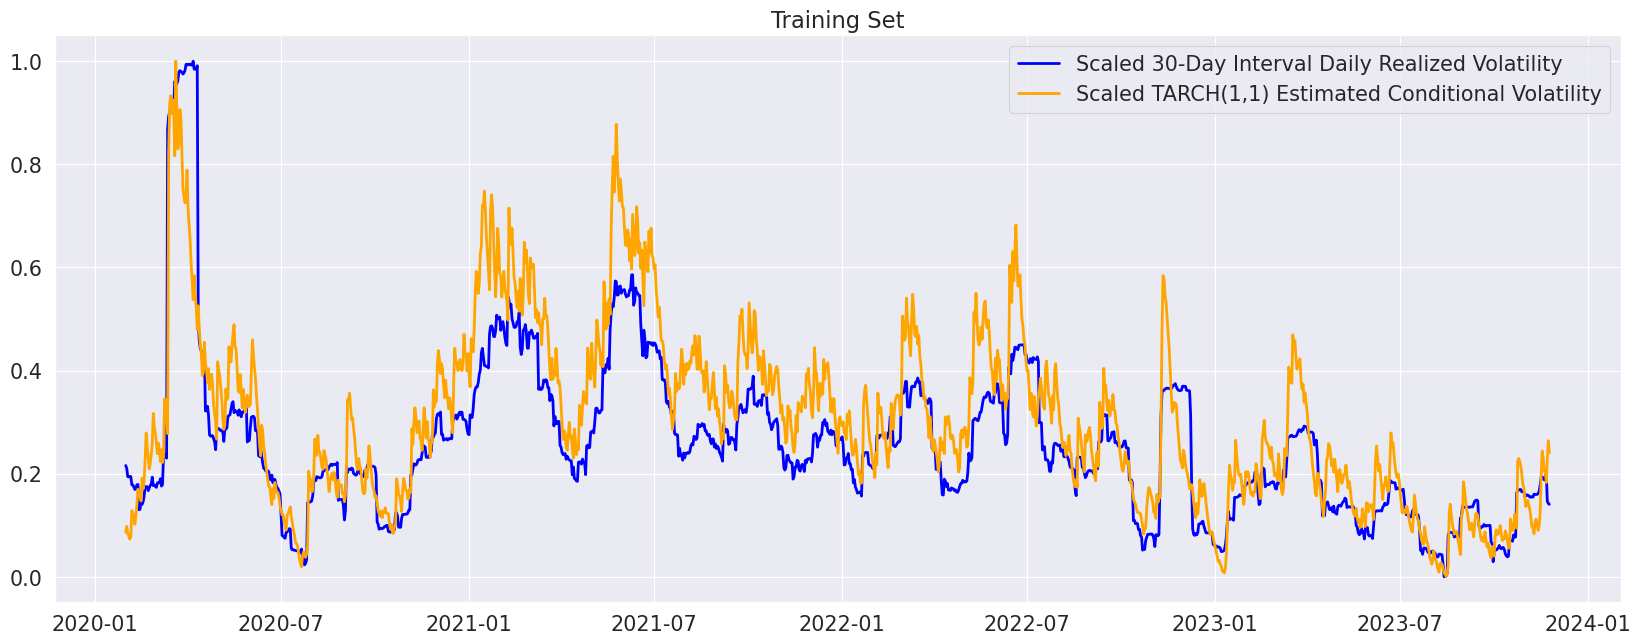

In [ ]:
viz_cond_vol(scaled_tarch_cond_vol, 'TARCH(1,1)')

3.3.1. Bootstrap-based Forecasting for TARCH(1,1)


In [ ]:
# ROLLING WINDOW FORECAST
# INITIALIZING rolling_forecasts VALUES LIST
rolling_forecasts = []

# ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
for i in range(len(val_idx)):
    # GET THE DATA AT ALL PREVIOUS TIME STEPS
    idx = val_idx[i]
    train = df.returns[:idx].dropna()

    # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
    model = arch_model(train, p=1, o=1, q=1, power=1.0,
                       dist='skewt')
    model_fit = model.fit(disp='off')

    # MAKE PREDICTION n_future DAYS OUT
    # USING BOOTSTRAP METHOD
    vaR = model_fit.forecast(horizon=n_future,
                             reindex=False,
                             method='bootstrap').variance.values
    pred = np.sqrt(np.mean(vaR))

    # APPEND TO rolling_forecasts LIST
    rolling_forecasts.append(pred)

t_bs_preds = pd.DataFrame(rolling_forecasts, index=val_idx)

In [ ]:
# TRANSFORM PREDICTIONS USING FITTED SCALER
t_bs_preds_scaled = transform_volatility_to_scaler(scaler_tarch, t_bs_preds)

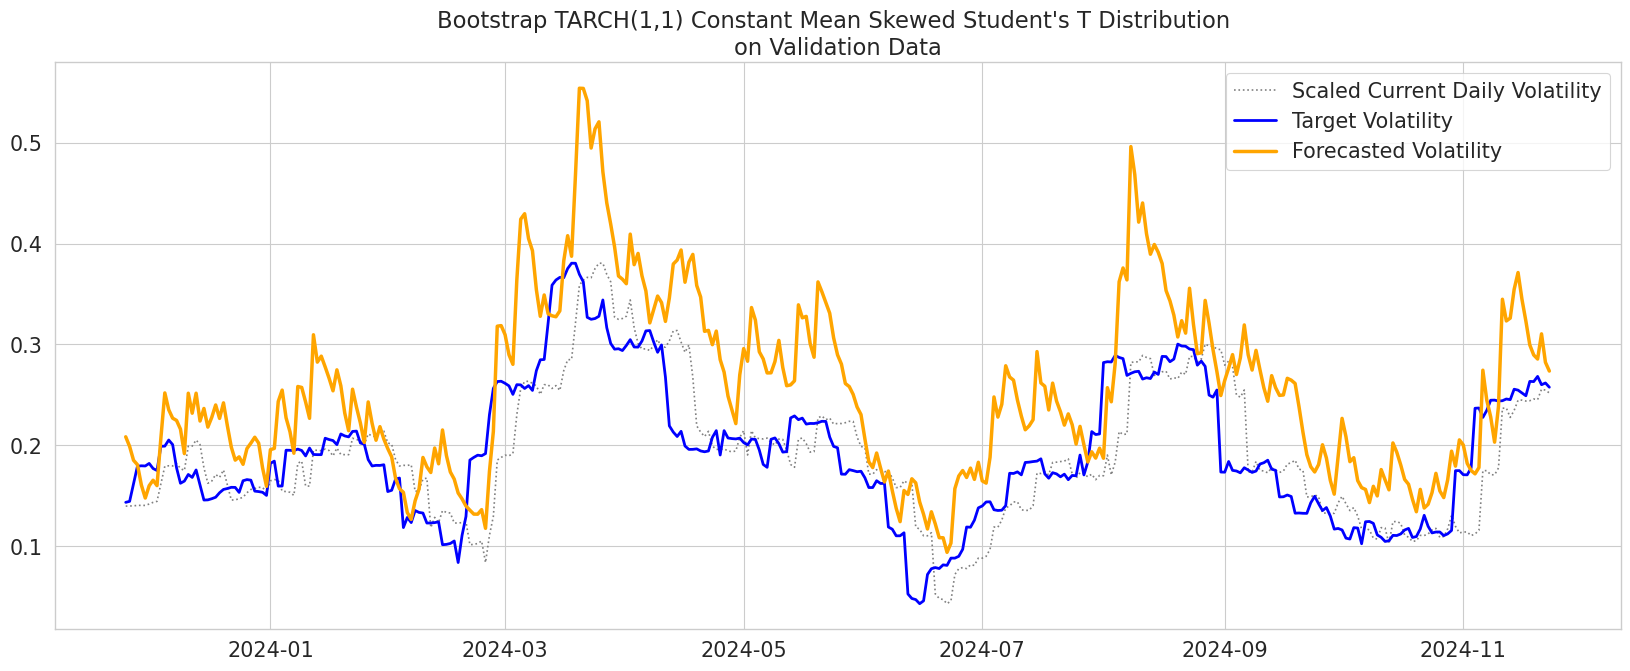

In [ ]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, t_bs_preds_scaled,
          "Bootstrap TARCH(1,1) Constant Mean Skewed Student's T Distribution")

In [ ]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, t_bs_preds_scaled,
         "Bootstrap TARCH(1,1), Constant Mean, Skewt Dist")

Model  Validation RMSPE  \
0                                           Mean Baseline          0.878159   
1                           Random Walk Naive Forecasting          0.306851   
2                  GARCH(1,1), Constant Mean, Normal Dist          0.467404   
3  Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist          0.241276   
4         Bootstrap TARCH(1,1), Constant Mean, Skewt Dist          0.497253   

   Validation RMSE  
0         0.092369  
1         0.042442  
2         0.095364  
3         0.044797  
4         0.079247

3.3.2. Simulation-based Forecasting for TARCH(1,1)


In [ ]:
# ROLLING WINDOW FORECAST
# INITIALIZING rolling_forecasts VALUES LIST
rolling_forecasts = []

# ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
for i in range(len(val_idx)):
    # GET THE DATA AT ALL PREVIOUS TIME STEPS
    idx = val_idx[i]
    train = df.returns[:idx].dropna()

    # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
    model = arch_model(train, p=1, o=1, q=1, power=1.0,
                       dist='skewt')
    model_fit = model.fit(disp='off')

    # MAKE PREDICTION n_future DAYS OUT
    # USING SIMULATION METHOD
    vaR = model_fit.forecast(horizon=n_future,
                             reindex=False,
                             method='simulation').variance.values
    pred = np.sqrt(np.mean(vaR))

    # APPEND TO rolling_forecasts LIST
    rolling_forecasts.append(pred)

t_sm_preds = pd.DataFrame(rolling_forecasts, index=val_idx)


In [ ]:
t_sm_preds

0
Date                               
2023-11-25 00:00:00+00:00  2.931917
2023-11-26 00:00:00+00:00  2.887653
2023-11-27 00:00:00+00:00  2.801011
2023-11-28 00:00:00+00:00  2.771102
2023-11-29 00:00:00+00:00  2.671075
...                             ...
2024-11-19 00:00:00+00:00  3.375919
2024-11-20 00:00:00+00:00  3.360046
2024-11-21 00:00:00+00:00  3.489310
2024-11-22 00:00:00+00:00  3.334905
2024-11-23 00:00:00+00:00  3.315700

[365 rows x 1 columns]

In [ ]:
# TRANSFORM PREDICTIONS USING FITTED SCALER
t_sm_preds_scaled = transform_volatility_to_scaler(scaler_tarch, t_sm_preds)

In [ ]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, t_sm_preds_scaled,"Simulation TARCH(1,1), Constant Mean, Skewt Dist")

Model  Validation RMSPE  \
0                                           Mean Baseline          0.878159   
1                           Random Walk Naive Forecasting          0.306851   
2                  GARCH(1,1), Constant Mean, Normal Dist          0.467404   
3  Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist          0.241276   
4         Bootstrap TARCH(1,1), Constant Mean, Skewt Dist          0.497253   
5        Simulation TARCH(1,1), Constant Mean, Skewt Dist          0.493065   

   Validation RMSE  
0         0.092369  
1         0.042442  
2         0.095364  
3         0.044797  
4         0.079247  
5         0.078491

3.3.3. Hyperparameter Tuning for TARCH

In [ ]:
import itertools

In [ ]:
pqo_s = [p for p in itertools.product(range(3), repeat=3)]
# ELIMINATE PERMUTATIONS WITH p = 0
pqo_s = list(filter(lambda x: x[0] != 0, pqo_s))
# RMSPE ON VALIDATION SET
rmspe_s = []
# LOG LIKELIHOOD
LLH_s = []
# BIC
bic_s = []

for p, q, o in pqo_s:
    # SET SEED FOR REPRODUCIBILITY
    np.random.seed(seed)

    # FITTING TARCH(p,q,o) MODEL
    t_gm_pqo = arch_model(r_train, p=p, q=q, o=o, power=1.0,
                          dist='skewt')
    t_gm_pqo_fit = t_gm_pqo.fit(disp='off')

    # SCALING CONDITIONAL VOLATILITY OUTPUTS
    sclr = MinMaxScaler()
    cond_vol_arr = t_gm_pqo_fit.conditional_volatility.values.reshape(-1,1)

    # FITTING SCALER TO MODEL'S CONDITIONAL VOLATILITY
    sclr = sclr.fit(cond_vol_arr)

    # INITIALIZING rolling_forecasts VALUES LIST
    rolling_forecasts = []

    # ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
    for i in range(len(r_val)):
        # GET THE DATA AT ALL PREVIOUS TIME STEPS
        idx = val_idx[i]
        train = df.returns[:idx].dropna()

        # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
        model = arch_model(train, p=p, q=q, o=o, power=1.0,
                          dist='skewt')
        model_fit = model.fit(disp='off')

        # MAKE PREDICTION
        vaR = model_fit.forecast(horizon=n_future,
                                 reindex=False,
                                 method='bootstrap').variance.values
        pred = np.sqrt(np.mean(vaR))

        # APPEND TO rolling_forecasts LIST
        rolling_forecasts.append(pred)
        # CONVERT PREDICTIONS
    y_preds = pd.Series(rolling_forecasts, index=val_idx)

    # TRANSFORM PREDICTIONS USING FITTED SCALER FOR SPECIFIC p/q/o SET
    y_preds_scaled = transform_volatility_to_scaler(sclr, y_preds)

    # APPENDING PERFORMANCE METRICS TO LISTS
    LLH_s.append(t_gm_pqo_fit.loglikelihood)
    bic_s.append(t_gm_pqo_fit.bic)
    rmspe_s.append(RMSPE(y_val_scaled, y_preds_scaled))


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr

In [ ]:
# GET THE VALUES OF p/q/o THAT YIELDS LOWEST VALIDATION RMSPE
print(f'Lowest RMSPE is {np.min(rmspe_s)} using TARCH{pqo_s[np.argmin(rmspe_s)]}')


Lowest RMSPE is 0.4107946429572777 using TARCH(2, 2, 2)


In [ ]:
best_pqo = pqo_s[np.argmin(rmspe_s)]

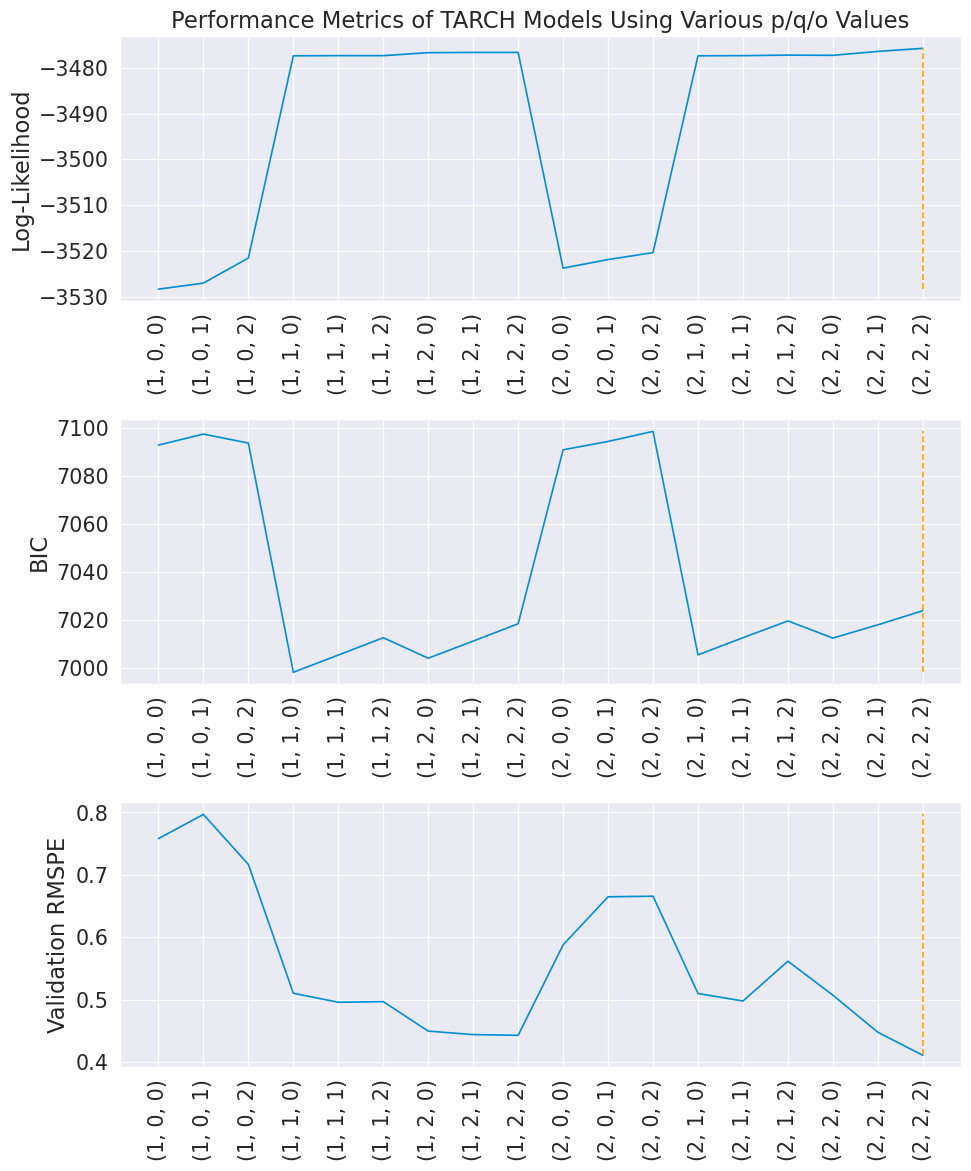

In [ ]:
with sns.axes_style("darkgrid"):
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(10,12))
    xlabels = [str(v) for v in pqo_s]

    ax1.plot(xlabels, LLH_s)
    ax1.set_xticklabels(xlabels, rotation=90)
    ax1.vlines(x=str(best_pqo),
               ls='--', color='orange',
               ymin=np.min(LLH_s), ymax=np.max(LLH_s))
    ax1.set_ylabel('Log-Likelihood')

    ax2.plot(xlabels, bic_s)
    ax2.set_xticklabels(xlabels, rotation=90)
    ax2.vlines(x=str(best_pqo),
               ls='--', color='orange',
               ymin=np.min(bic_s), ymax=np.max(bic_s))
    ax2.set_ylabel('BIC')

    ax3.plot(xlabels, rmspe_s)
    ax3.set_xticklabels(xlabels, rotation=90)
    ax3.vlines(x=str(best_pqo),
               ls='--', color='orange',
               ymin=np.min(rmspe_s), ymax=np.max(rmspe_s))
    ax3.set_ylabel('Validation RMSPE')

    ax1.set_title('Performance Metrics of TARCH Models Using Various p/q/o Values')
    plt.tight_layout()
    plt.show();

3.4. Final GARCH Model - TARCH(1,2)

In [ ]:
# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

t_120 = arch_model(r_train, p=best_pqo[0], q=best_pqo[1], o=best_pqo[2], power=1.0,
                  dist='skewt')
result_4 = t_120.fit(disp='off')
print(result_4.summary())

                        Constant Mean - TARCH/ZARCH Model Results                        
Dep. Variable:                           returns   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                           TARCH/ZARCH   Log-Likelihood:               -3475.71
Distribution:      Standardized Skew Student's t   AIC:                           6971.42
Method:                       Maximum Likelihood   BIC:                           7023.82
                                                   No. Observations:                 1394
Date:                           Wed, May 07 2025   Df Residuals:                     1393
Time:                                   15:03:50   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
--------------------------------------------

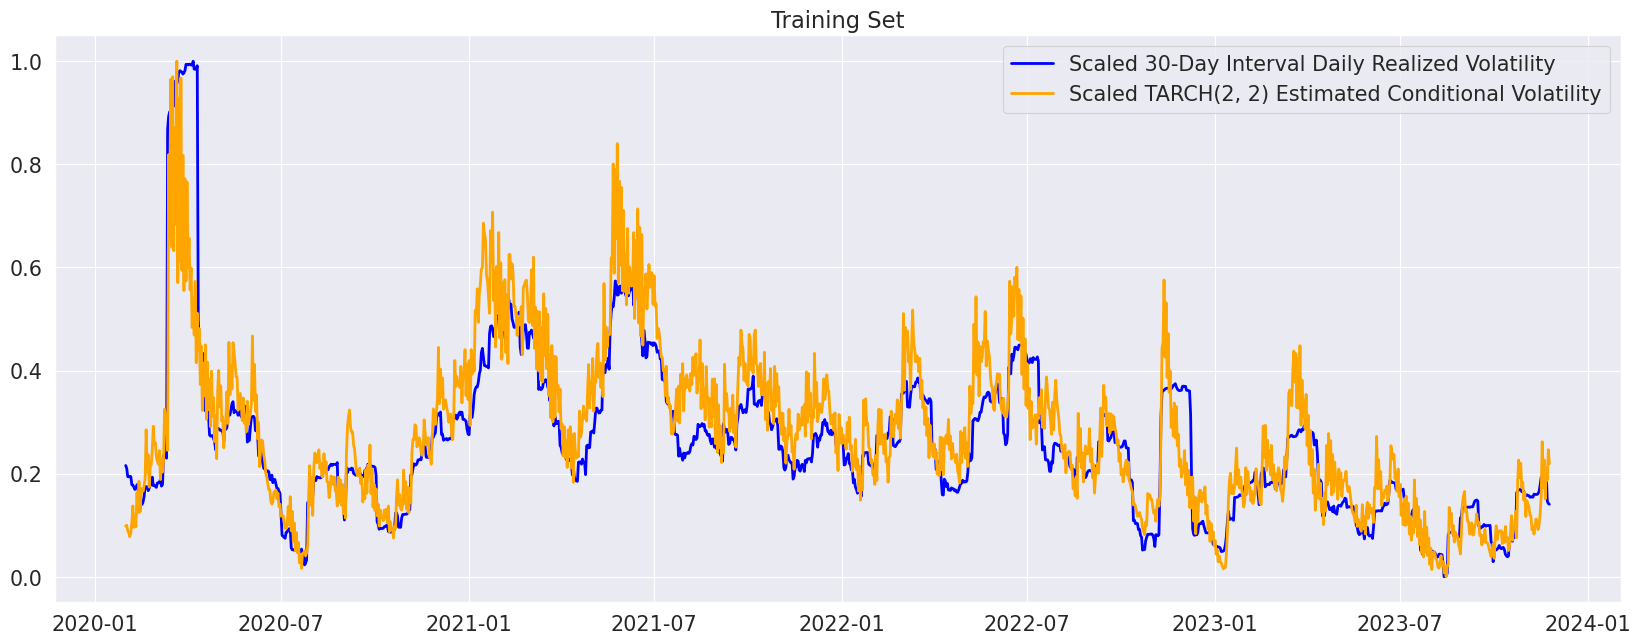

In [ ]:
# GET VOLATILITY SCALER & SCALED CONDITIONAL VOLATILITY FROM MODEL RESULT
scaler_tarch_120, scaled_tarch_120_cond_vol = scale_tf_cond_vol(result_4)
viz_cond_vol(scaled_tarch_120_cond_vol, f'TARCH{best_pqo[:2]}')

In [ ]:
# ROLLING WINDOW FORECAST
# INITIALIZING rolling_forecasts VALUES LIST
rolling_forecasts = []

# ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
for i in range(len(val_idx)):
    # GET THE DATA AT ALL PREVIOUS TIME STEPS
    idx = val_idx[i]
    train = df.returns[:idx].dropna()

    # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
    model = arch_model(train, p=best_pqo[0], q=best_pqo[1], o=best_pqo[2], power=1.0,
                       dist='skewt')
    model_fit = model.fit(disp='off')

    # MAKE PREDICTION n_future DAYS OUT
    # USING BOOTSTRAP METHOD
    vaR = model_fit.forecast(horizon=n_future,
                             reindex=False,
                             method='bootstrap').variance.values
    pred = np.sqrt(np.mean(vaR))

    # APPEND TO rolling_forecasts LIST
    rolling_forecasts.append(pred)

t_bs_120_preds = pd.DataFrame(rolling_forecasts, index=val_idx)

In [ ]:
# TRANSFORM PREDICTIONS USING FITTED SCALER
t_120_preds_scaled = transform_volatility_to_scaler(scaler_tarch_120, t_bs_120_preds)

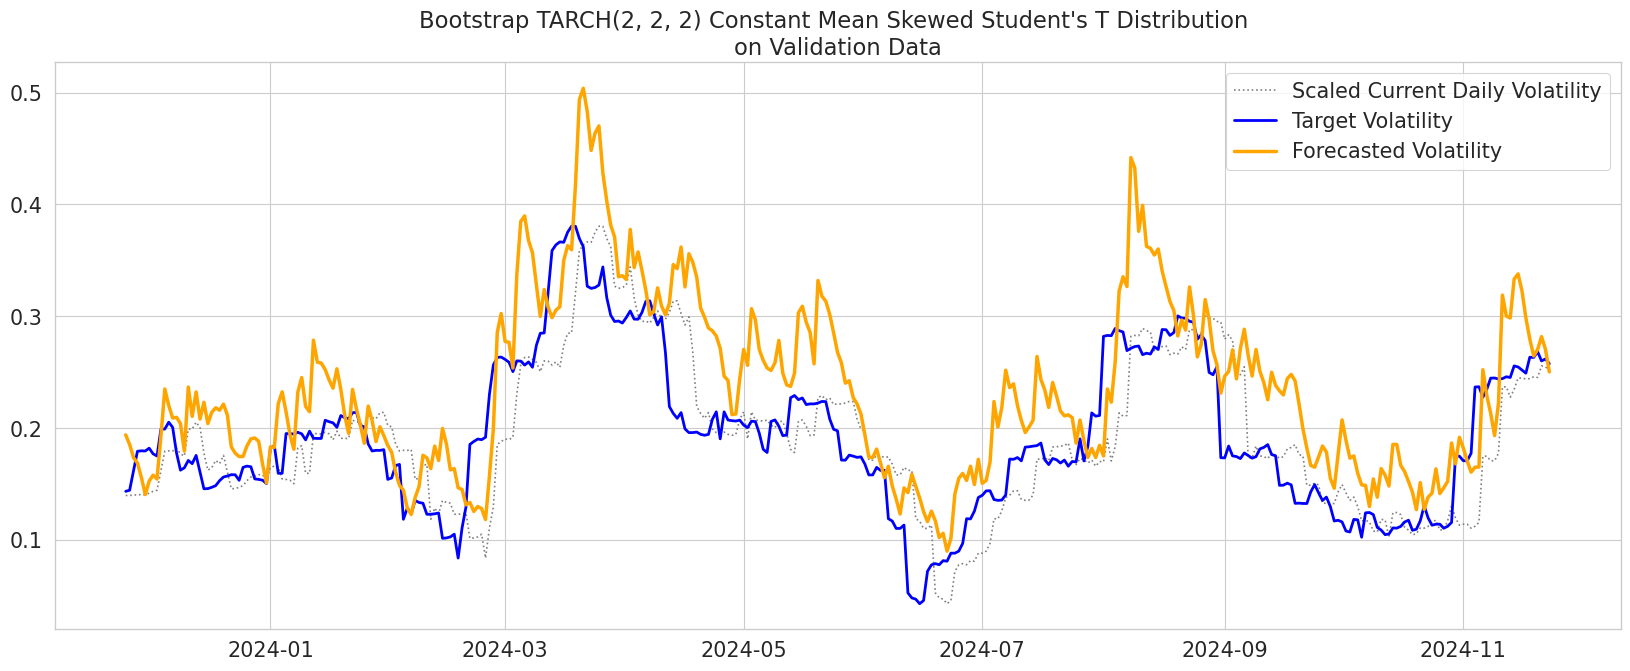

In [ ]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, t_120_preds_scaled,
          f"Bootstrap TARCH{best_pqo} Constant Mean Skewed Student's T Distribution")

In [ ]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, t_120_preds_scaled,
         f"Bootstrap TARCH{best_pqo}, Constant Mean, Skewt Dist")

Model  Validation RMSPE  \
0                                           Mean Baseline          0.878159   
1                           Random Walk Naive Forecasting          0.306851   
2                  GARCH(1,1), Constant Mean, Normal Dist          0.467404   
3  Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist          0.241276   
4         Bootstrap TARCH(1,1), Constant Mean, Skewt Dist          0.497253   
5        Simulation TARCH(1,1), Constant Mean, Skewt Dist          0.493065   
6     Bootstrap TARCH(2, 2, 2), Constant Mean, Skewt Dist          0.411345   

   Validation RMSE  
0         0.092369  
1         0.042442  
2         0.095364  
3         0.044797  
4         0.079247  
5         0.078491  
6         0.061107

# Neural Networks

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import backend as K
from decimal import Decimal

In [ ]:
# CONVERT AN SERIES TO MATRIX DATASET
def windowed_dataset(x_series, y_series, lookback_window):
    dataX, dataY = [], []
    for i in range((lookback_window-1), len(x_series)):
        start_idx = x_series.index[i-lookback_window+1]
        end_idx = x_series.index[i]
        a = x_series[start_idx:end_idx].values
        dataX.append(a)
        dataY.append(y_series[end_idx])

    return np.array(dataX), np.array(dataY)

In [ ]:
def rmspe(y_true, y_pred):
    '''
    Compute Root Mean Square Percentage Error between two arrays
    that can be used as metrics for NN during training
    '''
    loss = K.sqrt(K.mean(K.square((y_true - y_pred) / y_true)))

    return loss

In [ ]:
def forecast(model, range_idx):
    start_idx = range_idx[0] - timedelta(n_past - 1)
    end_idx = range_idx[-1]
    mat_X, _ = windowed_dataset(df.vol_current[start_idx:end_idx],
                                df.vol_future[range_idx], n_past)
    preds = pd.Series(model.predict(mat_X)[:, 0],
                      index=range_idx)

    return preds

In [ ]:
def scale(scaler, y_series):
    scaled = pd.Series(scaler.transform(y_series.values.reshape(-1,1))[:, 0],
                       index=y_series.index)
    return scaled

In [ ]:
def viz_train_val_metrics(model_hist):
    with sns.axes_style("white"):
        fig, ax = plt.subplots(figsize=(15,6))

        # PLOT MSE - LEFT Y-AXIS
        # TRAINING
        ln11 = ax.plot(range(len(model_hist.history['loss'])),
                    model_hist.history['loss'], color='lightblue',
                    label='Training MSE', lw=2)
        # VALIDATION
        ln12 = ax.plot(range(len(model_hist.history['loss'])),
                    model_hist.history['val_loss'], color='darkblue',
                    label='Validation MSE', lw=2)
        ax.set_xlabel('Epoch')
        ax.set_ylabel('MSE')

        # PLOT RMSE - RIGHT Y-AXIS
        ax2 = ax.twinx()
        ln21 = ax2.plot(range(len(model_hist.history['loss'])),
                    model_hist.history['rmspe'], color='pink', lw=2,
                    label='Training RMSPE')
        ln22 = ax2.plot(range(len(model_hist.history['loss'])),
                    model_hist.history['val_rmspe'], color='red', lw=2,
                    label='Validation RMSPE')
        ax2.set_ylabel('RMSPE')

        # COMBINING LALBELS FOR 4 LINES INTO 1 LEGEND
        lns = ln11 + ln12 + ln21 + ln22
        labs = [l.get_label() for l in lns]
        ax.legend(lns, labs, loc='best')

        ax.set_title('Training vs. Validation Learning Curves')
        plt.show();


.1. Neural Network Baseline Metrics - Fully Connected Network**


In [ ]:
# CLEARING ANY INTERNAL VARIABLES TO PREVENT MODELS
# FROM IMPACTING LATER VERSIONS OF THEMSELVES
tf.keras.backend.clear_session()
np.random.seed(seed)

n_past = 14
batch_size = 64

mat_X_train, mat_y_train = windowed_dataset(x_train, y_train, n_past)

snn_1 = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=[n_past, 1]),
    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

snn_1.compile(loss='mse',
              optimizer='adam',
              metrics=[rmspe])

print(snn_1.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 14)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            15 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15 (60.00 B)

 Trainable params: 15 (60.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
# FIT MODEL TO TRAINING DATASET
snn_1_res = snn_1.fit(mat_X_train, mat_y_train, epochs=100,
                      validation_split=0.2,
                      verbose=0, batch_size=batch_size,
                      shuffle=True)

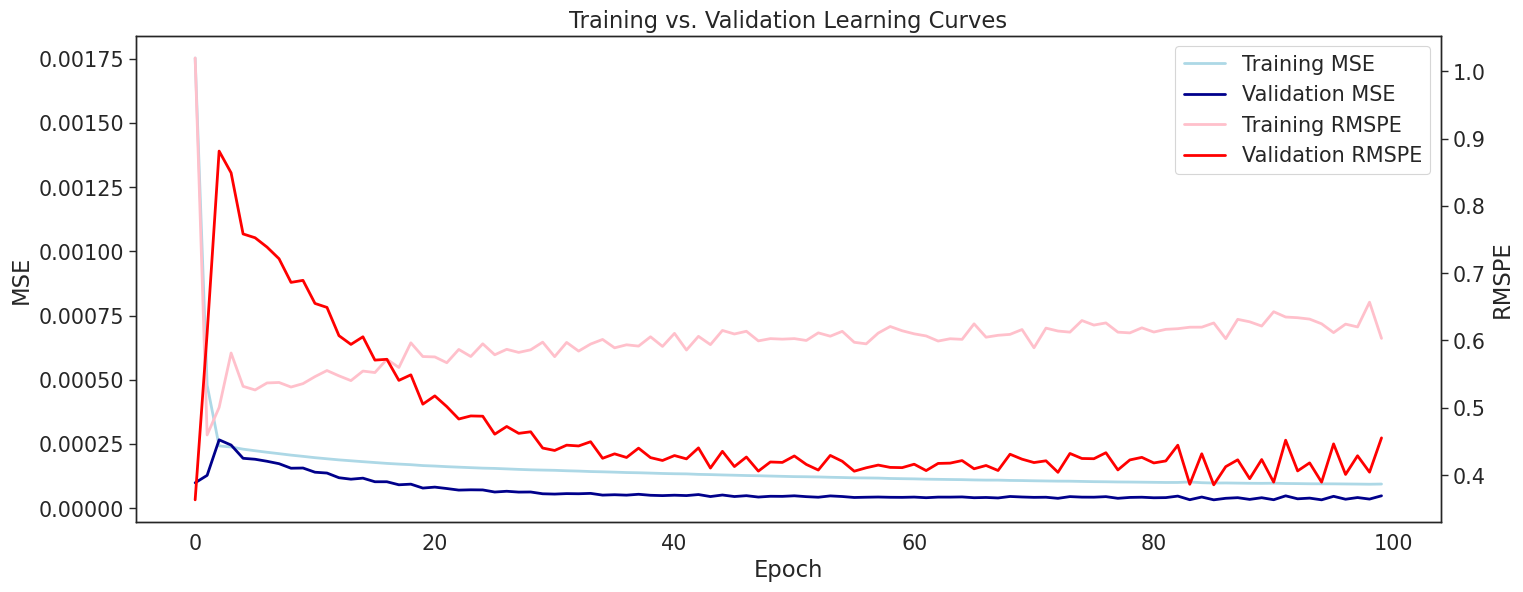

In [ ]:
viz_train_val_metrics(snn_1_res)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


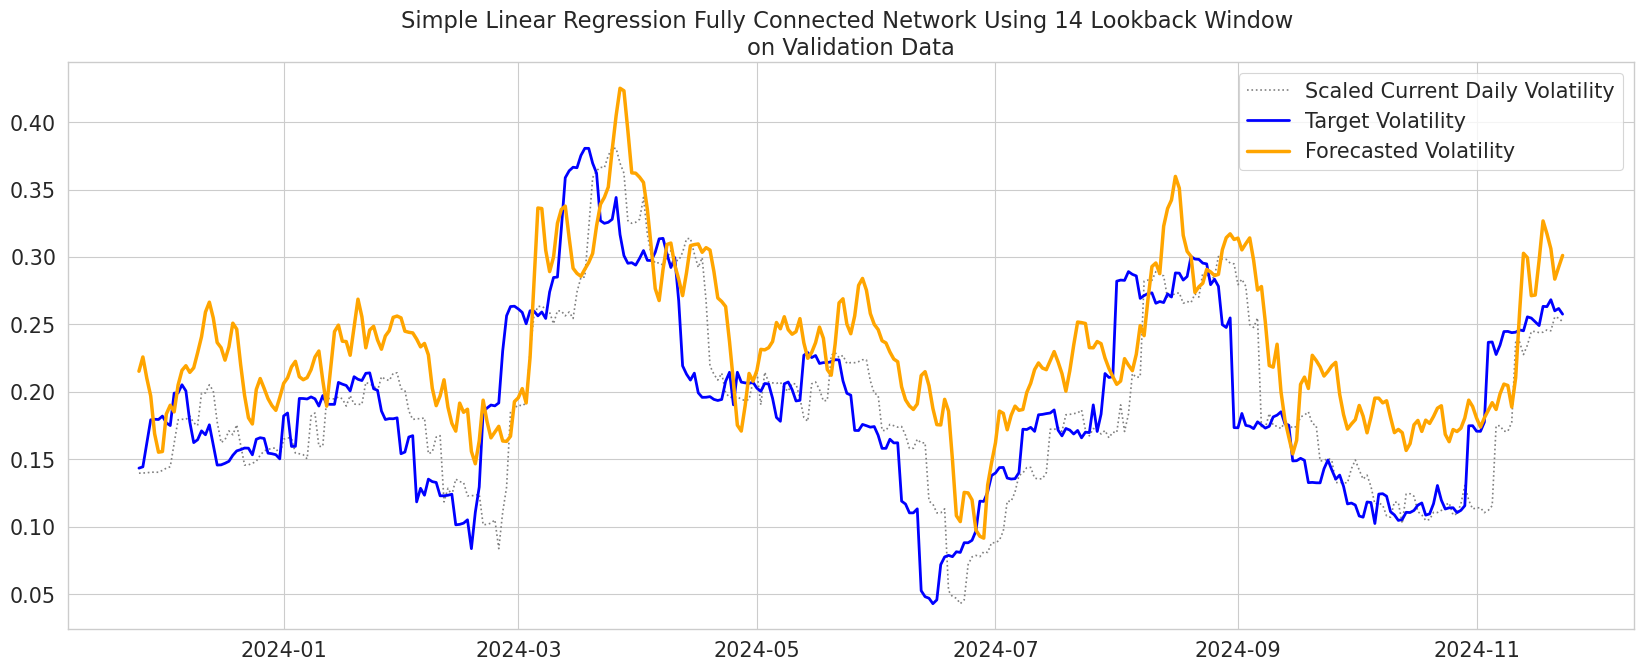

In [ ]:
# FORECASTING ON VALIDATION SET
snn_1_preds = forecast(snn_1, val_idx)

# SCALING OUTPUT TO MINMAXSCALER FITTED TO TRAINING CURRENT VOLUME
snn_1_preds_scaled = scale(scaler_vol, snn_1_preds)
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, snn_1_preds_scaled,
          f"Simple Linear Regression Fully Connected Network Using {n_past} Lookback Window")


In [ ]:
 #APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, snn_1_preds_scaled,
         f"Simple LR Fully Connected NN, n_past={n_past}")

Model  Validation RMSPE  \
0                                           Mean Baseline          0.878159   
1                           Random Walk Naive Forecasting          0.306851   
2                  GARCH(1,1), Constant Mean, Normal Dist          0.467404   
3  Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist          0.241276   
4         Bootstrap TARCH(1,1), Constant Mean, Skewt Dist          0.497253   
5        Simulation TARCH(1,1), Constant Mean, Skewt Dist          0.493065   
6     Bootstrap TARCH(2, 2, 2), Constant Mean, Skewt Dist          0.411345   
7                 Simple LR Fully Connected NN, n_past=14          0.544020   

   Validation RMSE  
0         0.092369  
1         0.042442  
2         0.095364  
3         0.044797  
4         0.079247  
5         0.078491  
6         0.061107  
7         0.061959

*4.2. Univariate Long Short-Term Memory (LSTM)****

In [ ]:
# CLEARING ANY INTERNAL VARIABLES TO PREVENT MODELS
# FROM IMPACTING LATER VERSIONS OF THEMSELVES
tf.keras.backend.clear_session()

# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

n_past = 14
batch_size = 64

mat_X_train, mat_y_train = windowed_dataset(x_train, y_train, n_past)

lstm_1 = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                           input_shape=[None]),
    # ADDING 1 LSTM LAYER
    tf.keras.layers.LSTM(20),
    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lstm_1.compile(loss='mse',
               optimizer="adam",
               metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_1.h5',
                                save_best_only=True,
                                monitor='val_rmspe',
                                mode='min')  # Add mode='min' here

early_stopping_cb = EarlyStopping(patience=30,
                                  restore_best_weights=True,
                                  monitor='val_rmspe',
                                  mode='min')  # Add mode='min' here


print(lstm_1.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda (Lambda)                 │ (None, None, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 20)             │         1,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,781 (6.96 KB)

 Trainable params: 1,781 (6.96 KB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
# FIT TO TRAINING DATA
lstm_1_res = lstm_1.fit(mat_X_train, mat_y_train,
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_split=0.2, shuffle=True,
                        verbose=0, batch_size=batch_size, epochs=200)

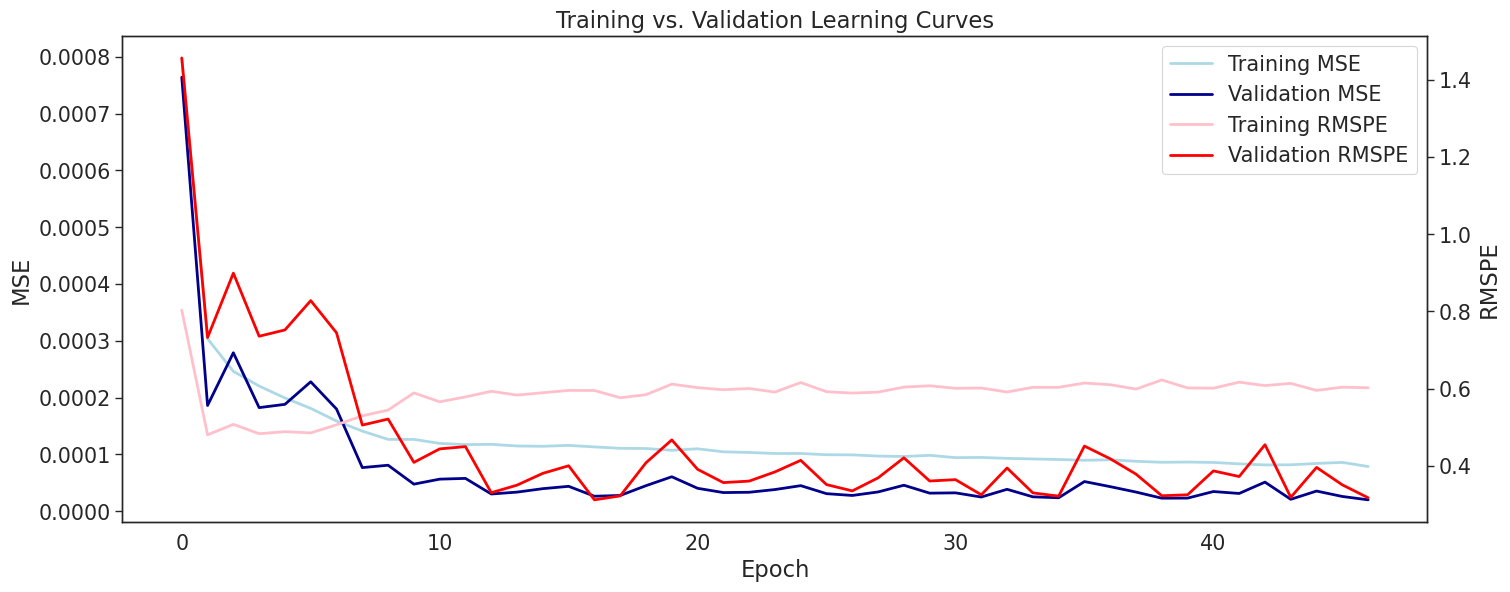

In [ ]:
# VISUALIZE TRAINING VS. VALIDATION LOSS METRICS
viz_train_val_metrics(lstm_1_res)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


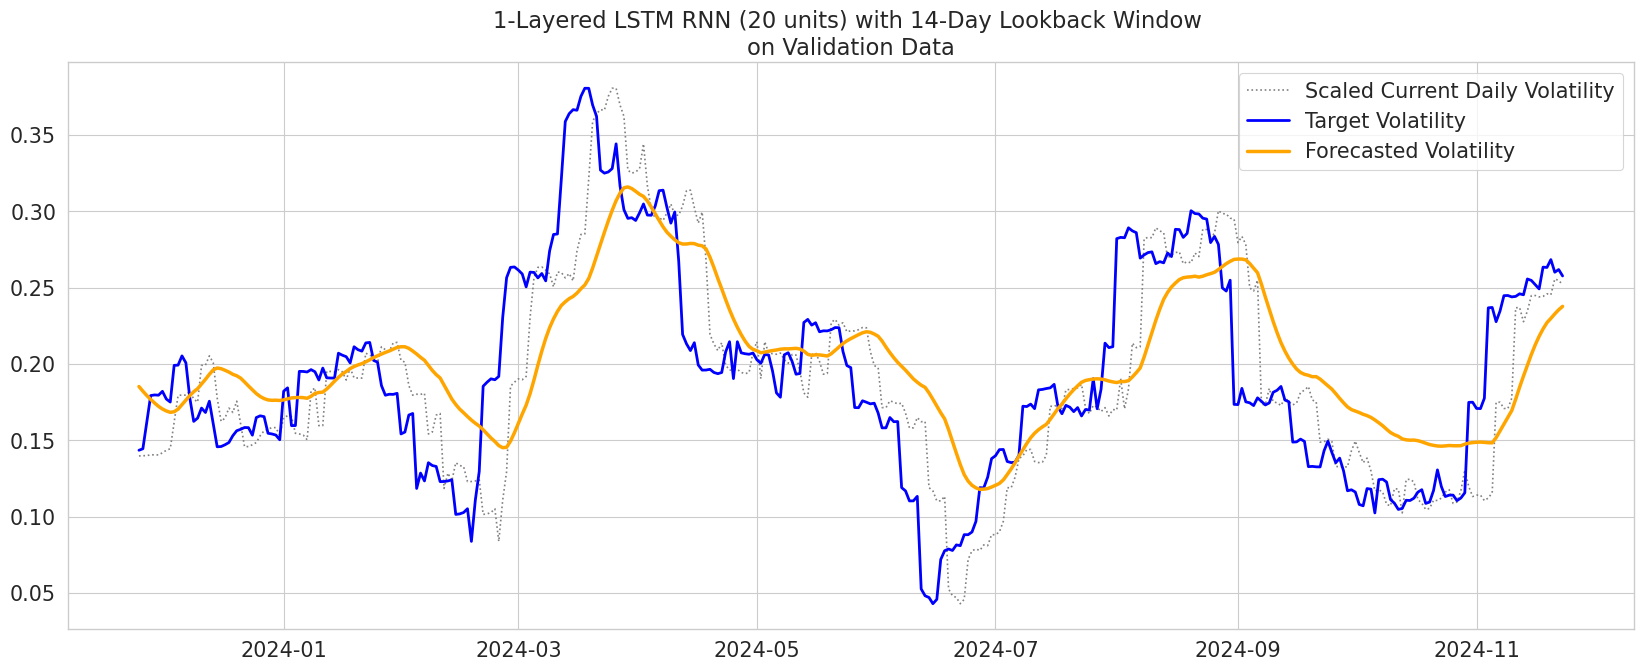

In [ ]:
 #FORECASTING ON VALIDATION SET
lstm_1_preds = forecast(lstm_1, val_idx)

# SCALING OUTPUT TO MINMAXSCALER FITTED TO TRAINING CURRENT VOLUME
lstm_1_preds_scaled = scale(scaler_vol, lstm_1_preds)
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, lstm_1_preds_scaled,
          f"1-Layered LSTM RNN (20 units) with {n_past}-Day Lookback Window")


In [ ]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, lstm_1_preds_scaled,
         f"LSTM 1 layer 20 units, n_past={n_past}")

Model  Validation RMSPE  \
0                                           Mean Baseline          0.878159   
1                           Random Walk Naive Forecasting          0.306851   
2                  GARCH(1,1), Constant Mean, Normal Dist          0.467404   
3  Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist          0.241276   
4         Bootstrap TARCH(1,1), Constant Mean, Skewt Dist          0.497253   
5        Simulation TARCH(1,1), Constant Mean, Skewt Dist          0.493065   
6     Bootstrap TARCH(2, 2, 2), Constant Mean, Skewt Dist          0.411345   
7                 Simple LR Fully Connected NN, n_past=14          0.544020   
8                        LSTM 1 layer 20 units, n_past=14          0.446470   

   Validation RMSE  
0         0.092369  
1         0.042442  
2         0.095364  
3         0.044797  
4         0.079247  
5         0.078491  
6         0.061107  
7         0.061959  
8         0.051081

## Input reshaping


In [ ]:
# SEPARATE INPUT DATAFRAME FROM df
input_df = df[features]

# SEPARATE INPUTS FOR TRAINING SET ONLY
X_train = input_df.loc[train_idx]

In [ ]:
X_train.head()

HL_sprd   CO_sprd     Volume  vol_current
Date                                                                 
2020-01-31 00:00:00+00:00 -3.470107 -0.016594  24.105365     0.029473
2020-02-01 00:00:00+00:00 -4.310758  0.004977  23.978383     0.028944
2020-02-02 00:00:00+00:00 -3.617181 -0.004841  24.151940     0.027421
2020-02-03 00:00:00+00:00 -3.461216 -0.005475  24.155125     0.027389
2020-02-04 00:00:00+00:00 -3.738311 -0.012039  24.120896     0.027483

In [ ]:
input_df.head()

HL_sprd   CO_sprd     Volume  vol_current
Date                                                                 
2020-01-31 00:00:00+00:00 -3.470107 -0.016594  24.105365     0.029473
2020-02-01 00:00:00+00:00 -4.310758  0.004977  23.978383     0.028944
2020-02-02 00:00:00+00:00 -3.617181 -0.004841  24.151940     0.027421
2020-02-03 00:00:00+00:00 -3.461216 -0.005475  24.155125     0.027389
2020-02-04 00:00:00+00:00 -3.738311 -0.012039  24.120896     0.027483

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1394 entries, 2020-01-31 00:00:00+00:00 to 2023-11-24 00:00:00+00:00
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   HL_sprd      1394 non-null   float64
 1   CO_sprd      1394 non-null   float64
 2   Volume       1394 non-null   float64
 3   vol_current  1394 non-null   float64
dtypes: float64(4)
memory usage: 54.5 KB


In [ ]:
input_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1789 entries, 2020-01-31 00:00:00+00:00 to 2024-12-23 00:00:00+00:00
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   HL_sprd      1789 non-null   float64
 1   CO_sprd      1789 non-null   float64
 2   Volume       1789 non-null   float64
 3   vol_current  1789 non-null   float64
dtypes: float64(4)
memory usage: 134.4 KB


In [ ]:
def forecast_multi(model, range_idx):
    start_idx = range_idx[0] - timedelta(n_past - 1)
    end_idx = range_idx[-1]
    mat_X, _ = windowed_dataset(input_df[start_idx:end_idx],
                                df.vol_future[range_idx], n_past)
    preds = pd.Series(model.predict(mat_X)[:, 0],
                      index=range_idx)

    return preds

**4.7. Multivariate 2-Layered Bidirectional LSTM with Dropout**

In [ ]:
tf.keras.backend.clear_session()

# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

n_past = 30
batch_size = 64
n_dims = input_df.shape[1]

mat_X_train, mat_y_train = windowed_dataset(X_train, y_train, n_past)

# CONSTRUCTING MULTIVARIATE BIDIRECTIONAL LSTM NN
lstm_5 = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=[n_past, n_dims]),
    # BATCH NORMALIZATION
    tf.keras.layers.BatchNormalization(),

    # ADDING 1st LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Dropout(0.1),

    # ADDING 2nd LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dropout(0.1),

    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lstm_5.compile(loss='mse',
               optimizer="adam",
               metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_5.h5',
                                save_best_only=True,
                                monitor='val_rmspe')

early_stopping_cb = EarlyStopping(
    patience=30,
    restore_best_weights=True,
    monitor='val_rmspe',  # This is fine
    mode='min'            # <==== THIS IS IMPORTANT TO ADD
)


print(lstm_5.summary())

NameError: name 'input_df' is not defined

In [ ]:
# FITTING TO TRAINING DATA
lstm_5_res = lstm_5.fit(mat_X_train, mat_y_train,
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_split=0.2, shuffle=True,
                        verbose=0, batch_size=batch_size, epochs=200)
# VISUALIZING LEARNING CURVES
viz_train_val_metrics(lstm_5_res)

NameError: name 'lstm_5' is not defined

In [ ]:
# FORECASTING ON VALIDATION SET
lstm_5_preds = forecast_multi(lstm_5, val_idx)

# SCALING OUTPUT TO MINMAXSCALER FITTED TO TRAINING CURRENT VOLUME
lstm_5_preds_scaled = scale(scaler_vol, lstm_5_preds)


In [ ]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, lstm_5_preds_scaled,
          f"Multivariate 2 Bidirect LSTM layers (32/16 units), {n_past} days look back")

In [ ]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, lstm_5_preds_scaled,
         f"Multivariate Bidirect LSTM 2 layers (32/16 units), n_past={n_past}")

Feature engineering


In [ ]:
df.head()

Open         High          Low        Close  \
Date                                                                            
2020-01-31 00:00:00+00:00  9508.313477  9521.706055  9230.776367  9350.529297   
2020-02-01 00:00:00+00:00  9346.357422  9439.323242  9313.239258  9392.875000   
2020-02-02 00:00:00+00:00  9389.820312  9468.797852  9217.824219  9344.365234   
2020-02-03 00:00:00+00:00  9344.683594  9540.372070  9248.633789  9293.521484   
2020-02-04 00:00:00+00:00  9292.841797  9331.265625  9112.811523  9180.962891   

                                Volume   returns  log_returns  vol_current  \
Date                                                                         
2020-01-31 00:00:00+00:00  29432489719 -1.666463    -0.016805     0.029473   
2020-02-01 00:00:00+00:00  25922656496  0.452870     0.004518     0.028944   
2020-02-02 00:00:00+00:00  30835736946 -0.516453    -0.005178     0.027421   
2020-02-03 00:00:00+00:00  30934096509 -0.544111    -0.005456     0.027389   
2020-02-04 00:00:00+00:00  29893183716 -1.211151    -0.012185     0.027483   

                           vol_future  
Date                                   
2020-01-31 00:00:00+00:00    0.025884  
2020-02-01 00:00:00+00:00    0.025492  
2020-02-02 00:00:00+00:00    0.025049  
2020-02-03 00:00:00+00:00    0.025339  
2020-02-04 00:00:00+00:00    0.025920

In [ ]:
df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1789 entries, 2020-01-31 00:00:00+00:00 to 2024-12-23 00:00:00+00:00
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Open         1789 non-null   float64
 1   High         1789 non-null   float64
 2   Low          1789 non-null   float64
 3   Close        1789 non-null   float64
 4   Volume       1789 non-null   int64  
 5   returns      1789 non-null   float64
 6   log_returns  1789 non-null   float64
 7   vol_current  1789 non-null   float64
 8   vol_future   1789 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 204.3 KB


In [ ]:
df.describe()


Open           High            Low          Close  \
count    1789.000000    1789.000000    1789.000000    1789.000000   
mean    36477.313224   37282.220498   35642.142402   36522.303223   
std     20624.460704   21089.868442   20151.357324   20657.932531   
min      5002.578125    5331.833984    4106.980957    4970.788086   
25%     20127.234375   20420.990234   19689.169922   20159.503906   
50%     32985.757812   34222.074219   31493.160156   33086.234375   
75%     50736.371094   51948.968750   49074.605469   50784.539062   
max    106147.296875  108268.445312  105291.734375  106140.601562   

             Volume      returns  log_returns  vol_current   vol_future  
count  1.789000e+03  1789.000000  1789.000000  1789.000000  1789.000000  
mean   3.323657e+10     0.186257     0.001285     0.031989     0.031975  
std    1.966957e+10     3.365114     0.034198     0.013754     0.013760  
min    5.331173e+09   -37.169539    -0.464730     0.009005     0.009005  
25%    2.050800e+10    -1.296730    -0.013052     0.023740     0.023740  
50%    3.000563e+10     0.065967     0.000659     0.029563     0.029563  
75%    4.028956e+10     1.648188     0.016348     0.037194     0.037194  
max    3.509679e+11    18.746474     0.171821     0.103878     0.103878

In [ ]:
df['HL_sprd'] = np.log((df.High - df.Low) / df.Close)
df['CO_sprd'] = (df.Close - df.Open) / df.Open
df['Volume'] = np.log(df.Volume)
df.head()

Open         High          Low        Close  \
Date                                                                            
2020-01-31 00:00:00+00:00  9508.313477  9521.706055  9230.776367  9350.529297   
2020-02-01 00:00:00+00:00  9346.357422  9439.323242  9313.239258  9392.875000   
2020-02-02 00:00:00+00:00  9389.820312  9468.797852  9217.824219  9344.365234   
2020-02-03 00:00:00+00:00  9344.683594  9540.372070  9248.633789  9293.521484   
2020-02-04 00:00:00+00:00  9292.841797  9331.265625  9112.811523  9180.962891   

                              Volume   returns  log_returns  vol_current  \
Date                                                                       
2020-01-31 00:00:00+00:00  24.105365 -1.666463    -0.016805     0.029473   
2020-02-01 00:00:00+00:00  23.978383  0.452870     0.004518     0.028944   
2020-02-02 00:00:00+00:00  24.151940 -0.516453    -0.005178     0.027421   
2020-02-03 00:00:00+00:00  24.155125 -0.544111    -0.005456     0.027389   
2020-02-04 00:00:00+00:00  24.120896 -1.211151    -0.012185     0.027483   

                           vol_future   HL_sprd   CO_sprd  
Date                                                       
2020-01-31 00:00:00+00:00    0.025884 -3.470107 -0.016594  
2020-02-01 00:00:00+00:00    0.025492 -4.310758  0.004977  
2020-02-02 00:00:00+00:00    0.025049 -3.617181 -0.004841  
2020-02-03 00:00:00+00:00    0.025339 -3.461216 -0.005475  
2020-02-04 00:00:00+00:00    0.025920 -3.738311 -0.012039

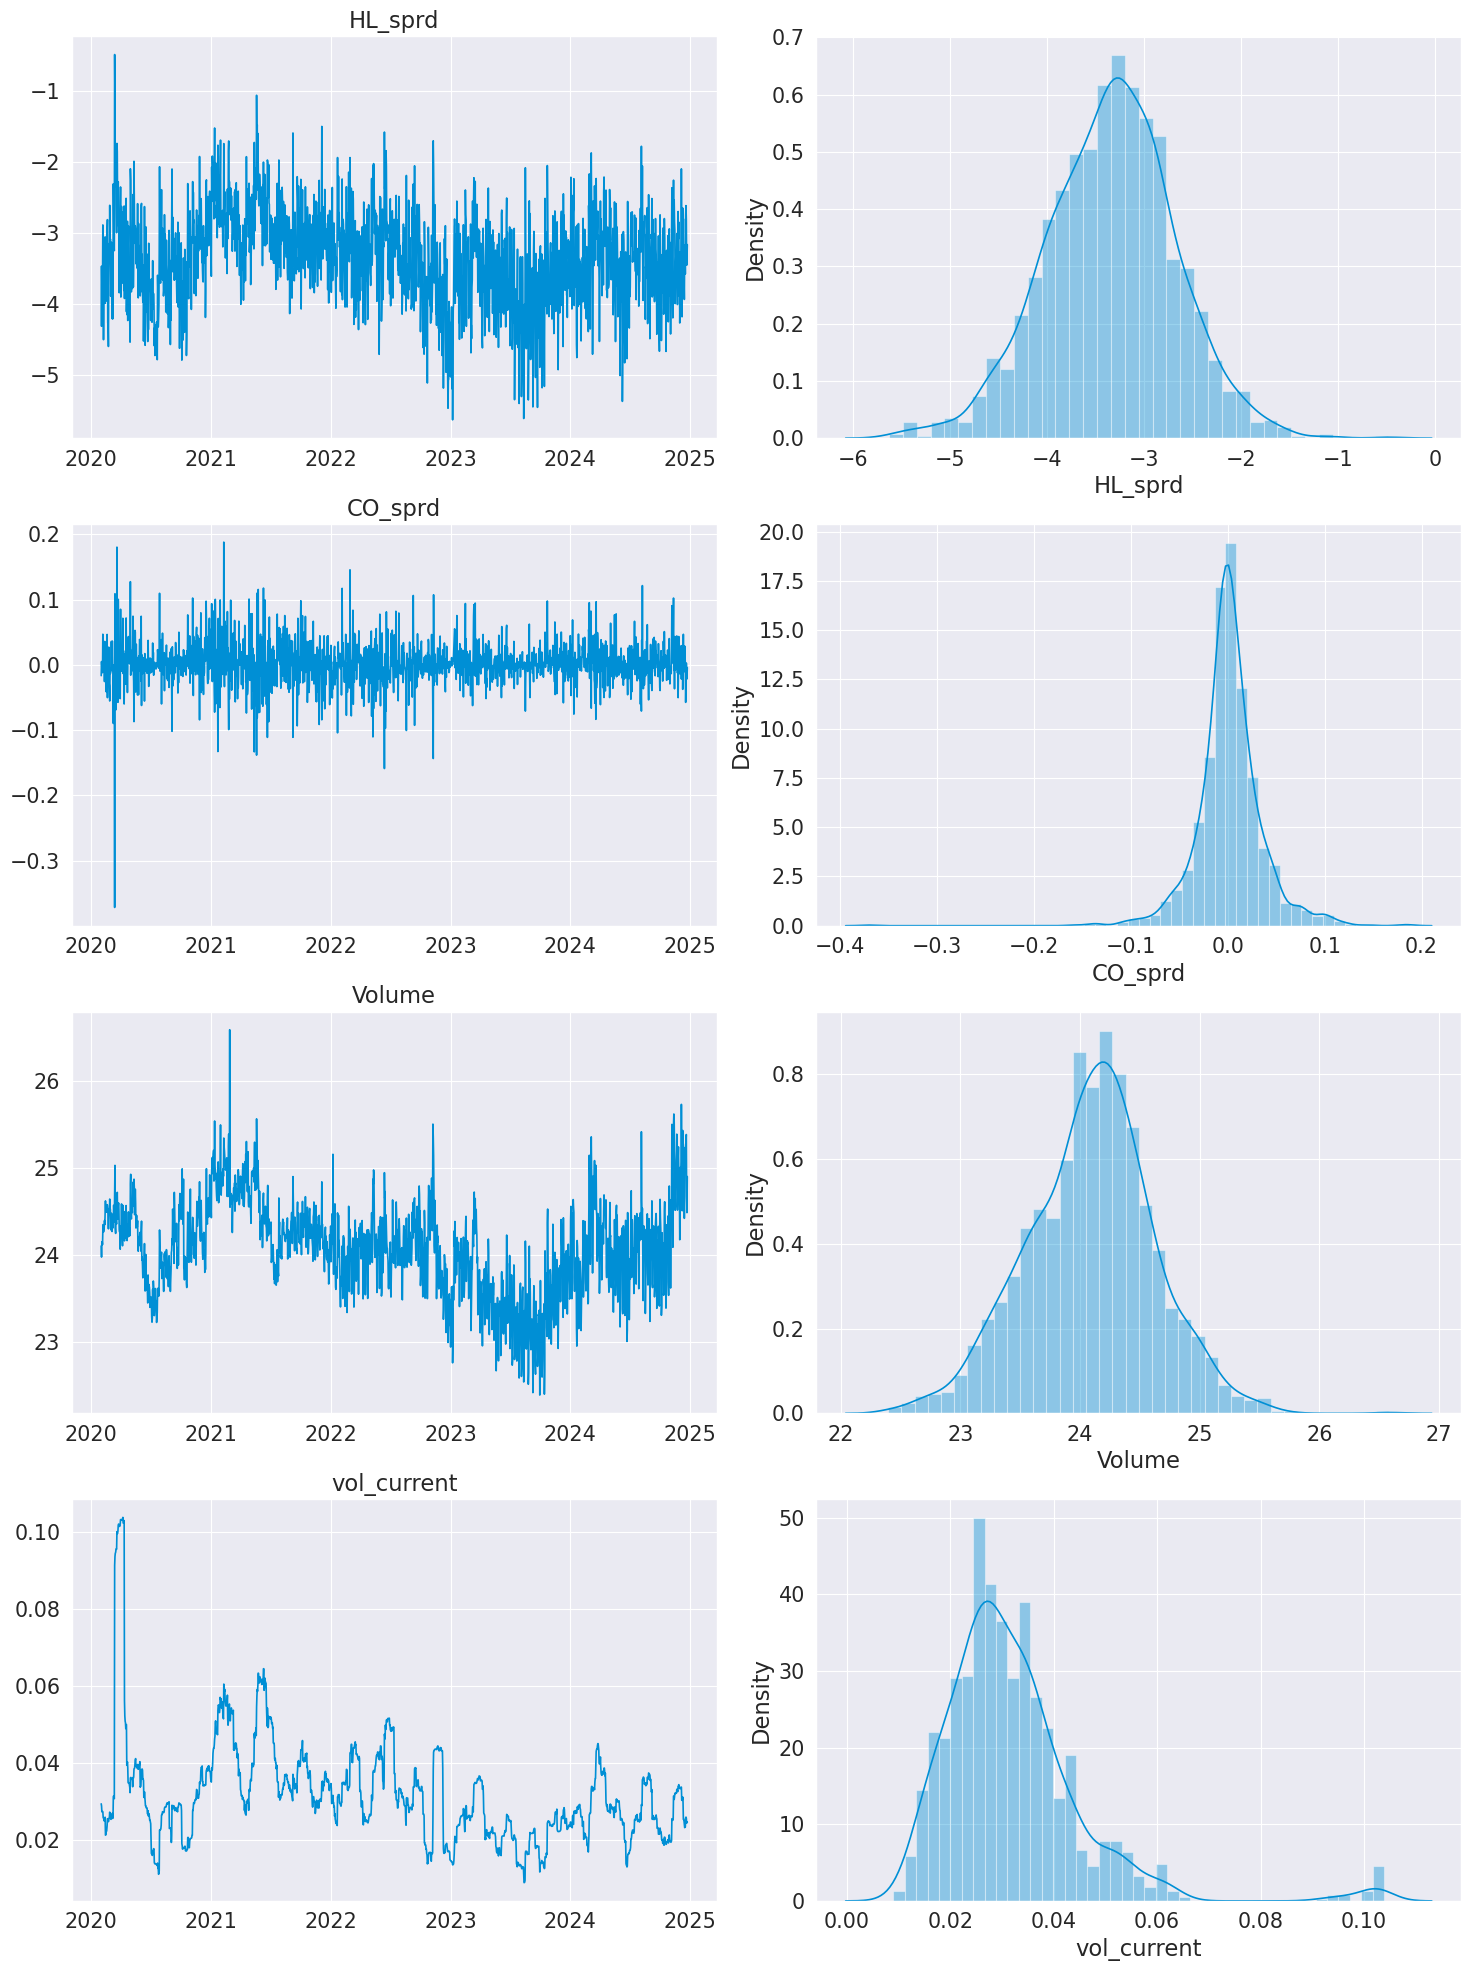

In [ ]:
features = ['HL_sprd', 'CO_sprd', 'Volume', 'vol_current']
# PLOT EACH NUMERICAL COLUMN
with sns.axes_style("darkgrid"):
    fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15,20))

    for i, c in enumerate(features):
        ax1, ax2 = axes[i][0], axes[i][1]
        ax1.plot(df[c])
        ax1.set_title(c)

        sns.distplot(df[c], ax=ax2)

    plt.tight_layout()

In [ ]:
# SEPARATE INPUT DATAFRAME FROM df
input_df = df[features]

# SEPARATE INPUTS FOR TRAINING SET ONLY
X_train = input_df.loc[train_idx]
X_train.head()

HL_sprd   CO_sprd     Volume  vol_current
Date                                                                 
2020-01-31 00:00:00+00:00 -3.470107 -0.016594  24.105365     0.029473
2020-02-01 00:00:00+00:00 -4.310758  0.004977  23.978383     0.028944
2020-02-02 00:00:00+00:00 -3.617181 -0.004841  24.151940     0.027421
2020-02-03 00:00:00+00:00 -3.461216 -0.005475  24.155125     0.027389
2020-02-04 00:00:00+00:00 -3.738311 -0.012039  24.120896     0.027483

In [ ]:
input_df.head()

HL_sprd   CO_sprd     Volume  vol_current
Date                                                                 
2020-01-31 00:00:00+00:00 -3.470107 -0.016594  24.105365     0.029473
2020-02-01 00:00:00+00:00 -4.310758  0.004977  23.978383     0.028944
2020-02-02 00:00:00+00:00 -3.617181 -0.004841  24.151940     0.027421
2020-02-03 00:00:00+00:00 -3.461216 -0.005475  24.155125     0.027389
2020-02-04 00:00:00+00:00 -3.738311 -0.012039  24.120896     0.027483

In [ ]:
def forecast_multi(model, range_idx):
    start_idx = range_idx[0] - timedelta(n_past - 1)
    end_idx = range_idx[-1]
    mat_X, _ = windowed_dataset(input_df[start_idx:end_idx],
                                df.vol_future[range_idx], n_past)
    preds = pd.Series(model.predict(mat_X)[:, 0],
                      index=range_idx)

    return preds


# Final GARCH Model

In [ ]:
# CREATE DATASET THAT COMBINES BOTH TRAINING & VALIDATION
tv_df = input_df[:split_time_2]
tv_y = df.vol_future[:split_time_2]

In [ ]:
tf.keras.backend.clear_session()

# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

n_past = 30
batch_size = 64
n_dims = input_df.shape[1]

mat_X_tv, mat_y_tv = windowed_dataset(tv_df, tv_y, n_past)

# CONSTRUCTING MULTIVARIATE BIDIRECTIONAL LSTM NN
lstm_final = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=[n_past, n_dims]),
    # BATCH NORMALIZATION
    tf.keras.layers.BatchNormalization(),

    # ADDING 1st LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Dropout(0.1),

    # ADDING 2nd LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dropout(0.1),

    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lstm_final.compile(loss='mse',
                    optimizer="adam",
                    metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_final.h5',
                                save_best_only=True,
                                monitor='val_rmspe')

# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING
early_stopping_cb = EarlyStopping(patience=30,
                                  restore_best_weights=True,
                                  monitor='val_rmspe',
    mode='min')

print(lstm_final.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization             │ (None, 30, 4)          │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 30, 64)         │         9,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 32)             │        10,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,889 (77.69 KB)

 Trainable params: 19,881 (77.66 KB)

 Non-trainable params: 8 (32.00 B)

None


In [ ]:
lstm_final_res = lstm_final.fit(mat_X_tv, mat_y_tv, epochs=500,
                                validation_split=0.2,
                                callbacks=[checkpoint_cb, early_stopping_cb],
                                verbose=0, batch_size=batch_size, shuffle=True)

In [ ]:
viz_train_val_metrics(lstm_final_res)

**Final Model's Predictions on Test Set**

In [ ]:
# FORECASTING ON VALIDATION SET
y_test_preds = forecast_multi(lstm_final, test_idx)
y_test_preds.describe()

In [ ]:
y_test.describe()


In [ ]:
q1 = df.vol_current[:split_time_2].describe()['25%']

q2 = df.vol_current[:split_time_2].describe()['50%']

q3 = df.vol_current[:split_time_2].describe()['75%']
from matplotlib.patches import Rectangle
import matplotlib.dates as mdates

In [ ]:
# PLOTTING MODEL PREDICTIONS VS. TARGET VALUES
with sns.axes_style("white"):
    fig, ax1 = plt.subplots(figsize=(18,7))
    # ZOOMING IN THE LAST n_display VALUES
    n_display = 365

    ax1.plot(df.vol_future[-n_display:], color='blue',
                label=f"Test Set Target Volatility")
    ax1.plot(df.vol_current[-n_display:], color='gray',  ls=':',
                label=f"Current Daily Volatility")
    ax1.plot(y_test_preds, color='orange', lw=3,
                label=f'Test Set Forecasted Volatility')

    q_colors = ['gray', 'black', 'gray']
    for i, q in enumerate([q1, q2, q3]):
        ax1.hlines(y=q, color=q_colors[i], alpha=0.5, label=f'Daily Volatility Q{i+1}', ls='-.', lw=1,
                    xmin=df.vol_future[-n_display:].index[0],
                    xmax=df.vol_future[-n_display:].index[-1])

    # ADD RECTANGLE TO PLOT AS BACKGROUND FOR TEST DATA
    w = len(test_idx) - 1
    h = df.vol_future[-n_display:].max() - df.vol_future[-n_display:].min()
    x0 = mdates.date2num(df.index[split_time_2])
    y0 = df.vol_future[-n_display:].min()
    rect = Rectangle((x0, y0), w, h, color ='green', alpha=0.1)
    ax1.add_patch(rect)

    # ADD TEXT
    ax1.text(df.index[(split_time_2 + 3)], 0.05,
             'Test Data\n(30 days)',
             fontsize=15, color='black')

    plt.title(f'Final Model Prediction on Test Set \n(Zooming in the Most Recent {n_display} Days)', fontsize=20)
    ax1.legend(loc='upper left', prop={'size': 14})
    plt.tight_layout()

In [ ]:
# GENERATING PREDICTIONS ON THE WHOLE DATASET (5 years)
mat_X_all, _ = windowed_dataset(input_df, df.vol_future, n_past)
preds_all = pd.Series(lstm_final.predict(mat_X_all)[:,0],
                      index=df.index[-(mat_X_all).shape[0]:])
# Ref: https://stackoverflow.com/questions/31162780/how-to-plot-a-rectangle-on-a-datetime-axis-using-matplotlib
# PLOTTING MODEL PREDICTIONS VS. TARGET VALUES
with sns.axes_style("white"):
    fig, ax1 = plt.subplots(figsize=(18,7))
    # ZOOMING IN THE LAST n_display VALUES
    n_display = 365

    ax1.plot(df.vol_future[-n_display:], color='blue',
                label=f"Next {n_future} days' Daily Volatility (Target)")
    ax1.plot(df.vol_current[-n_display:], color='gray',  ls='--',
                label=f"Current Daily Volatility")
    ax1.plot(preds_all[-n_display:], color='orange', lw=3,
                label=f'Forecasted Volatility')

    q_colors = ['gray', 'black', 'gray']
    for i, q in enumerate([q1, q2, q3]):
        ax1.hlines(y=q,
                   xmin=df.vol_future[-n_display:].index[0],
                   xmax=df.vol_future[-n_display:].index[-1],
                   label=f'Daily Volatility Q{i+1}',
                   ls='-.', lw=1, color=q_colors[i], alpha=0.5)

    # ADD RECTANGLE TO PLOT AS BACKGROUND FOR TEST DATA
    w = len(test_idx) - 1
    h = df.vol_future[-n_display:].max() - df.vol_future[-n_display:].min()
    x0 = mdates.date2num(df.index[split_time_2])
    y0 = df.vol_future[-n_display:].min()
    rect = Rectangle((x0, y0), w, h, color ='green', alpha=0.1)
    ax1.add_patch(rect)

    # ADD TEXT
    ax1.text(df.index[(split_time_2 + 3)], 0.05,
             'Test Data\n(30 days)',
             fontsize=15, color='black')

    plt.title(f'Final Model Predictions (Zooming in the Most Recent {n_display} Days)', fontsize=20)
    ax1.legend(loc='upper left', prop={'size': 14})
    plt.tight_layout()

In [ ]:
print('RMSPE on Test Set:', RMSPE(y_test, y_test_preds))

In [ ]:
1-RMSPE(y_test, y_test_preds)

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# CLEAR SESSION
tf.keras.backend.clear_session()

# SET SEED
np.random.seed(42)
tf.random.set_seed(42)

# PARAMETERS
n_past = 60        # Increased past window
batch_size = 32    # Smaller batch size
n_dims = input_df.shape[1]  # Assuming your input has multiple features

# Prepare your windowed data
mat_X_tv, mat_y_tv = windowed_dataset(tv_df, tv_y, n_past)

# BUILD LSTM MODEL
lstm_final = Sequential([
    Input(shape=(n_past, n_dims)),
    BatchNormalization(),

    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.2),

    Bidirectional(LSTM(32, return_sequences=True)),
    Dropout(0.2),

    Bidirectional(LSTM(16)),
    Dropout(0.2),

    Dense(1)
])

# Compile the model
lstm_final.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=[rmspe]   # Assuming you have defined RMSPE metric separately
)

# CALLBACKS
checkpoint_cb = ModelCheckpoint('best_lstm_model.h5', save_best_only=True, monitor='val_rmspe', mode='min')
early_stopping_cb = EarlyStopping(patience=50, restore_best_weights=True, monitor='val_rmspe', mode='min')
reduce_lr_cb = ReduceLROnPlateau(monitor='val_rmspe', factor=0.5, patience=10, verbose=1, mode='min')

# TRAIN THE MODEL
lstm_final_res = lstm_final.fit(
    mat_X_tv, mat_y_tv,
    epochs=500,
    batch_size=batch_size,
    validation_split=0.2,
    shuffle=True,
    verbose=1,
    callbacks=[checkpoint_cb, early_stopping_cb, reduce_lr_cb]
)

# View model summary
print(lstm_final.summary())


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle
import seaborn as sns

# Predict on entire dataset
mat_X_tv, mat_y_tv = windowed_dataset(tv_df, tv_y, n_past)
preds_all = pd.Series(lstm_final.predict(mat_X_all).flatten(), index=input_df.index[-len(mat_X_all):])

# Parameters
n_display = 365  # Number of days you want to zoom in at the end
test_period_days = 30  # Days to highlight as test region

# Plotting
with sns.axes_style("white"):
    fig, ax1 = plt.subplots(figsize=(18, 7))

    # Plot Actual Future Volatility
    ax1.plot(df.vol_future[-n_display:], label='Next Days\' Daily Volatility (Target)', color='blue')

    # Plot Current Volatility
    ax1.plot(df.vol_current[-n_display:], label='Current Daily Volatility', linestyle='--', color='gray')

    # Plot Predicted Volatility
    ax1.plot(preds_all[-n_display:], label='Forecasted Volatility (LSTM)', color='orange', linewidth=3)

    # Add Horizontal lines for Q1, Q2, Q3 (optional)
    q1 = df.vol_future[-n_display:].quantile(0.25)
    q2 = df.vol_future[-n_display:].quantile(0.5)
    q3 = df.vol_future[-n_display:].quantile(0.75)
    q_colors = ['gray', 'black', 'gray']
    for i, q in enumerate([q1, q2, q3]):
        ax1.hlines(q, xmin=df.index[-n_display], xmax=df.index[-1], colors=q_colors[i], linestyles='--', lw=1, alpha=0.5, label=f'Volatility Q{i+1}')

    # Highlight Last 30 Days Test Set Area
    x0 = mdates.date2num(df.index[-test_period_days])
    x1 = mdates.date2num(df.index[-1])
    y0 = df.vol_future[-n_display:].min()
    h = df.vol_future[-n_display:].max() - y0
    rect = Rectangle((x0, y0), x1 - x0, h, color='green', alpha=0.1)
    ax1.add_patch(rect)

    # Add text "Test Data (30 days)"
    ax1.text(df.index[-test_period_days + 3], y0 + 0.005, f'Test Data ({test_period_days} days)', fontsize=15, color='black')

    # Titles and labels
    plt.title(f'Final Model Predictions (Zooming in the Most Recent {n_display} Days)', fontsize=20)
    plt.xlabel('Date')
    plt.ylabel('Volatility')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


NameError: name 'windowed_dataset' is not defined

In [ ]:
import numpy as np

# Define the RMSPE function
def RMSPE(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))

# Calculate RMSPE between true volatility and predicted volatility
rmspe_value = RMSPE(df.vol_future[-n_display:], preds_all[-n_display:])

# Print the result
print(f'RMSPE on Test Set: {rmspe_value:.6f}')
